In [1]:
import sys
print(sys.version)
import os
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ['TF_USE_LEGACY_KERAS'] = "1"
!pip install torch torch_geometric


3.11.4 (main, Jul  5 2023, 13:45:01) [GCC 11.2.0]


In [15]:
import datetime
import copy
import torch
from torch.utils.data import TensorDataset
import logging
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random as python_random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#from bs4 import BeautifulSoup
#import xml.etree.ElementTree as Xet
from argparse import ArgumentParser
from neuralforecast import NeuralForecast
from neuralforecast.models import TFT
from neuralforecast.models import NBEATSx
from neuralforecast.losses.pytorch import MQLoss
from sklearn.preprocessing import MinMaxScaler
#from nbeats_pytorch.model import NBeatsNet
from sklearn.neighbors import NearestNeighbors
import statsmodels.api as sm
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Lambda
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

from sklearn.model_selection import train_test_split



In [3]:
class DataLoader:
    """
    Load data into desired formats for training/validation/testing, including preprocessing.
    """

    def __init__(self, horizon, back_horizon):
        self.horizon = horizon
        self.back_horizon = back_horizon
        self.scaler = list()
        self.historical_values = list()  # first by patient idx, then by col_idx

    def preprocessing(
        self,
        lst_train_arrays,
        lst_test_arrays,
        # train_mode=True, # flag for train_mode (split into train/val), test_mode (no split)
        train_size=0.8,
        normalize=False,
        sequence_stride=6,
        target_col=0,
        exog_cols=[1, 2, 3, 4],
        horizon=12
    ):
        self.normalize = normalize
        self.sequence_stride = sequence_stride
        self.target_col = target_col
        self.exog_cols = exog_cols
        train_arrays = copy.deepcopy(lst_train_arrays)
        test_arrays = copy.deepcopy(lst_test_arrays)
        # count valid timesteps for each individual series
        # train_array.shape = n_timesteps x n_features
        self.valid_steps_train = [train_array.shape[0] for train_array in train_arrays]
        train_lst, val_lst, test_lst = list(), list(), list()
        for idx in range(len(train_arrays)):
            #print(idx, "index")
            bg_sample_train = train_arrays[idx]
            #bg_sample_train_exog = np.delete(train_arrays[idx], 0, 1)
            bg_sample_test = test_arrays[idx]#[:, target_col]
            #bg_sample_test_exog = np.delete(test_arrays[idx], 0, 1)
            valid_steps_sample = self.valid_steps_train[idx]
            #train_target = bg_sample_train_target[: int(train_size * valid_steps_sample)].copy()
            train = bg_sample_train[: int(train_size * valid_steps_sample), :].copy()
            #val_target = bg_sample_train_target[int(train_size * valid_steps_sample) :].copy()
            val = bg_sample_train[int(train_size * valid_steps_sample) :, :].copy()
            #test_target = bg_sample_test_target[:].copy()
            test = bg_sample_test[:, :].copy()
            if self.normalize:
                scaler_cols = list()
                # train.shape = n_train_timesteps x n_features
                for col_idx in range(train.shape[1]):
                    scaler = MinMaxScaler(feature_range=(0, 1), clip=False)
                    train[:, col_idx] = remove_extra_dim(
                        scaler.fit_transform((add_extra_dim(train[:, col_idx])))
                    )
                    val[:, col_idx] = remove_extra_dim(
                        scaler.transform(add_extra_dim(val[:, col_idx]))
                    )
                    test[:, col_idx] = remove_extra_dim(
                        scaler.transform(add_extra_dim(test[:, col_idx]))
                    )
                    scaler_cols.append(scaler)  # by col_idx, each feature
                self.scaler.append(scaler_cols)  # by pat_idx, each patient
                
            lst_hist_values = list()
            for col_idx in range(train.shape[1]):
                all_train_col = np.concatenate((train[:, col_idx], val[:, col_idx]))
                # decimals = 1, 2 OR 3?
                unique_values = np.unique(np.round(all_train_col, decimals=2))
                lst_hist_values.append(unique_values)
            self.historical_values.append(lst_hist_values)

            train_lst.append(train)
            #train_lst_exog.append(train_exog)
            val_lst.append(val)
            #val_lst_exog.append(val_exog)
            test_lst.append(test)
            #test_lst_exog.append(test_exog)
        

        (
            self.X_train_exog,
            self.X_train_target,
            self.Y_train,#_exog,
            #self.Y_train_target,
            self.train_idxs,
        ) = self.create_sequences(
            train_lst,
            self.horizon,
            self.back_horizon,
            self.sequence_stride,
            self.target_col,
        )
        (
            self.X_val_exog,
            self.X_val_target,
            self.Y_val,#_exog,
            #self.Y_val_target,
            self.val_idxs,
        ) = self.create_sequences(
            val_lst,
            self.horizon,
            self.back_horizon,
            self.sequence_stride,
            self.target_col,
        )
        (
            self.X_test_exog,
            self.X_test_target,
            self.Y_test,#_exog,
            #self.Y_test_target,
            self.test_idxs,
        ) = self.create_sequences(
            test_lst,
            self.horizon,
            self.back_horizon,
            self.sequence_stride,
            self.target_col,
        )
        (
            self.X_reg_exog,
            self.X_reg_target,
            self.reg_idxs,
        ) = self.create_sequences_reg(
            test_lst,
            self.horizon,
            self.back_horizon,
            self.sequence_stride,
            self.target_col,
        )
        (
            self.X_reg_val_exog,
            self.X_reg_val_target,
            self.reg_val_idxs,
        ) = self.create_sequences_reg(
            test_lst,
            self.horizon,
            self.back_horizon,
            self.sequence_stride,
            self.target_col,
        )
        
    @staticmethod
    def create_sequences(
        series_lst, horizon, back_horizon, sequence_stride, target_col=0, exog=False
    ):
        X_exogs, X_targets, Ys, sample_idxs = list(), list(), list(), list()
        
        cnt_nans = 0
        for idx, series in enumerate(series_lst):
            len_series = series.shape[0]
            if len_series < (horizon + back_horizon):
                print(
                    f"Warning: not enough timesteps to split for sample {idx}, len: {len_series}, horizon: {horizon}, back: {back_horizon}."
                )
            for i in range(0, len_series - back_horizon - horizon, sequence_stride):
                input_series_exog = series[i : (i + back_horizon)]
                input_series_exog = np.delete(input_series_exog, [target_col], axis=1)
                input_series_target = series[i : (i + back_horizon), [target_col]]
                output_series = series[
                    (i + back_horizon) : (i + back_horizon + horizon), [target_col]
                ]
                #input_series_exog = np.delete(input_series_exog, [target_col], axis=1)
                #input_series_target = series[i : (i + back_horizon), [target_col]]
                #input_series_target = series[(i + back_horizon) : (i + back_horizon + horizon), [target_col]]
                
                # TODO: add future plans as additional variables (?)
                if np.isfinite(input_series_exog).all() and np.isfinite(input_series_target).all() and np.isfinite(output_series).all():
                    X_exogs.append(input_series_exog)
                    X_targets.append(input_series_target)
                    Ys.append(output_series)
                    #Xs_target.append(input_series_target)
                    # record the sample index when splitting
                    sample_idxs.append(idx)
                else:
                    cnt_nans += 1
                    if cnt_nans % 100 == 0:
                        print(f"{cnt_nans} strides skipped due to NaN values.")
                        
        #print("train", np.array(Xs), "test", np.array(Ys), "val", np.array(sample_idxs))
        return np.array(X_exogs), np.array(X_targets), np.array(Ys), np.array(sample_idxs)

    @staticmethod
    def create_sequences_reg(
        series_lst, horizon, back_horizon, sequence_stride, target_col=0, exog=False
    ):
        Xs_exog, Xs_target, sample_idxs = list(), list(), list()
        
        cnt_nans = 0
        for idx, series in enumerate(series_lst):
            len_series = series.shape[0]
            if len_series < (horizon + back_horizon):
                print(
                    f"Warning: not enough timesteps to split for sample {idx}, len: {len_series}, horizon: {horizon}, back: {back_horizon}."
                )
            for i in range(0, len_series - back_horizon - horizon, sequence_stride):
                output_series_exog = series[(i + back_horizon) : (i + back_horizon + horizon)]
                output_series_exog = np.delete(output_series_exog, [target_col], axis=1)
                output_series_target = series[(i + back_horizon) : (i + back_horizon + horizon), [target_col]]
                # TODO: add future plans as additional variables (?)
                if np.isfinite(output_series_exog).all() and np.isfinite(output_series_target).all():
                    Xs_exog.append(output_series_exog)
                    Xs_target.append(output_series_target)
                    # record the sample index when splitting
                    sample_idxs.append(idx)
                else:
                    cnt_nans += 1
                    if cnt_nans % 100 == 0:
                        print(f"{cnt_nans} strides skipped due to NaN values.")
                        
        #print("train", np.array(Xs), "test", np.array(Ys), "val", np.array(sample_idxs))
        return np.array(Xs_exog), np.array(Xs_target), np.array(sample_idxs)      


In [4]:
# remove an extra dimension
def remove_extra_dim(input_array):
    # 2d to 1d
    if len(input_array.shape) == 2:
        return np.reshape(input_array, (-1))
    # 3d to 2d (remove the last empty dim)
    elif len(input_array.shape) == 3:
        return np.squeeze(np.asarray(input_array), axis=-1)
    else:
        print("Not implemented.")
        #print(input_array, "JLNA;iknb")

# add an extra dimension
def add_extra_dim(input_array):
    # 1d to 2d
    if len(input_array.shape) == 1:
        return np.reshape(input_array, (-1, 1))
    # 2d to 3d
    elif len(input_array.shape) == 2:
        return np.asarray(input_array)[:, :, np.newaxis]
    else:
        print("Not implemented.")
        #print(input_array, "ALVNAPNV")

# Method: Fix the random seeds to get consistent models
def reset_seeds(seed_value=39):
    # ref: https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
    os.environ["PYTHONHASHSEED"] = str(seed_value)
    # necessary for starting Numpy generated random numbers in a well-defined initial state.
    np.random.seed(seed_value)
    # necessary for starting core Python generated random numbers in a well-defined state.
    python_random.seed(seed_value)
    # set_seed() will make random number generation
    tf.random.set_seed(seed_value)  

In [26]:
def prepare_data(dataset, data_path):
    df_train = []
    df_test = []
    df_train = pd.DataFrame(df_train)
    df_test = pd.DataFrame(df_test)
    if dataset == "simulated":
        for i,j in zip(["01","02","03","04","05","06","07","08","09","10"],[1,2,3,4,5,6,7,8,9,10]):
            a = pd.read_csv(f"../results/simulation_4/adult#0{i}.csv")
            a["Time"] = a[["Time"]].apply(
                lambda x: pd.to_datetime(x, errors="coerce", format="%Y-%m-%d %H:%M:%S")
            )
            #a['Time'] = pd.to_datetime(a['Time'])
            #a.rename(columns={"Time":"ds", "BG":"y"}, inplace=True)
            a = a.dropna()
            #date_index = pd.date_range(a.Time[0], periods=len(a),freq='3min')
            #a.index = date_index
            a['patient_id'] = pd.Series([f"{j}" for x in range(len(a.index))])
            idx = int(a.shape[0] * 0.8)
            cut = a.iloc[idx].Time
            a_train = a[a.Time<cut]
            a_test = a[a.Time>=cut]
            df_train = pd.concat([df_train, a_train], ignore_index=True)
            df_test = pd.concat([df_test, a_test], ignore_index=True)
        df_train.to_csv("data/data_simulation/all_train.csv")
        df_test.to_csv("data/data_simulation/all_test.csv")
        
    elif dataset == "ohiot1dm":
        train = []
        test = []
        train = pd.DataFrame(train)
        test = pd.DataFrame(test)
        for i in [540, 544, 552, 567, 584, 596, 559, 563, 570, 575, 588, 591]:
            file_train = pd.read_csv(data_path + "data_OhioT1DM/" + f"{i}_train.csv")
            file_test = pd.read_csv(data_path + "data_OhioT1DM/" + f"{i}_test.csv")
            
            file_train['patient_id'] = pd.Series([f"{i}" for x in range(len(file_train.index))])
            file_test['patient_id'] = pd.Series([f"{i}" for x in range(len(file_test.index))])
            
            train = pd.concat([train, file_train], ignore_index=True)
            test = pd.concat([train, file_test], ignore_index=True)
            
        train.to_csv(data_path + "data_OhioT1DM/all_train.csv")
        test.to_csv(data_path + "data_OhioT1DM/all_test.csv")

    elif dataset == "mimic":
        base_cluster_dir = data_path+"data_MIMIC/"+"cluster_csv"
        output_dir = data_path+"data_MIMIC/"+"combined_cluster_data"
        os.makedirs(output_dir, exist_ok=True)
        
        train = pd.DataFrame()
        test = pd.DataFrame()
        for cluster_id in ["0","1","2","3"]:
            cluster_folder = f"cluster_{cluster_id}"
            cluster_path = os.path.join(base_cluster_dir, cluster_folder)
            os.makedirs(output_dir, exist_ok=True)

            if not os.path.isdir(cluster_path):
                print(f"Cluster folder {cluster_folder} not found.")
                return
    
            print(f"Processing {cluster_folder}...")
    
            for file_name in sorted(os.listdir(cluster_path)):
                if not file_name.endswith(".csv"):
                    continue
        
                file_path = os.path.join(cluster_path, file_name)
                df = pd.read_csv(file_path)
        
                subject_id = int(file_name.split("_")[1].replace(".csv", ""))
                df['patient_id'] = subject_id
        
                if len(df) >= 2:
                    df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, shuffle=False)
                else:
                    df_train = df
                    df_test = pd.DataFrame(columns=df.columns)
        
                train = pd.concat([train, df_train], ignore_index=True)
                test = pd.concat([test, df_test], ignore_index=True)
        
            train.to_csv(os.path.join(output_dir, f"cluster_{cluster_id}_train.csv"), index=False)
            test.to_csv(os.path.join(output_dir, f"cluster_{cluster_id}_test.csv"), index=False)
        
            print(f"Cluster {cluster_id}: Train shape = {train.shape}, Test shape = {test.shape}")
            print(f"Files saved in {output_dir}")

                

In [27]:
def load_data(dataset, data_path):
    prepare_data(dataset, data_path)
    if dataset == "ohiot1dm":
        train, orig_train = load_ohio_data(data_path, "all_train.csv")
        test, orig_test = load_ohio_data(data_path, "all_test.csv")
    elif dataset == "simulated":
        train, orig_train = load_sim_data(data_path, "all_train.csv")
        test, orig_test = load_sim_data(data_path, "all_test.csv")
    elif dataset == "mimic":
        train, orig_train = load_mimic_data(os.path.join(data_path, "data_MIMIC/"))
        test, orig_test = load_mimic_data(os.path.join(data_path, "data_MIMIC/"))  # same for now
    else:
        print("No dataset chosen")
    return train, test, orig_train, orig_test

def load_ohio_data(data_path, file_name="all_train.csv"):
    # load all the patients, combined
    data = pd.read_csv(data_path + "data_OhioT1DM/" + file_name)

    from functools import reduce
    from operator import or_ as union

    def idx_union(mylist):
        idx = reduce(union, (index for index in mylist))
        return idx

    idx_missing = data.loc[data["missing"] != -1].index
    idx_missing_union = idx_union([idx_missing - 1, idx_missing])

    data = data.drop(idx_missing_union)
    data_bg = data[
        [
            "index_new",
            "patient_id",
            "glucose",
            "basal",
            "bolus",
            "carbs",
            "exercise_intensity",
        ]
    ]
    data_bg["time"] = data_bg[["index_new"]].apply(
        lambda x: pd.to_datetime(x, errors="coerce", format="%Y-%m-%d %H:%M:%S")
    )
    data_bg = data_bg.drop("index_new", axis=1)

    data_bg["bolus"][data_bg["bolus"] == -1] = 0
    data_bg["carbs"][data_bg["carbs"] == -1] = 0
    data_bg["exercise_intensity"][data_bg["exercise_intensity"] == -1] = 0
    data_bg["glucose"][data_bg["glucose"] == -1] = np.NaN

    lst_patient_id = [
        540,
        544,
        552,
        567,
        584,
        596,
        559,
        563,
        570,
        575,
        588,
        591,
    ]
    lst_arrays = list()
    for pat_id in lst_patient_id:
        lst_arrays.append(
            np.asarray(
                data_bg[data_bg["patient_id"] == pat_id][
                    [
                        "glucose",
                        "basal",
                        "bolus",
                        "carbs",
                        "exercise_intensity",
                    ]
                ]
            )
        )
    return lst_arrays, data_bg


def load_sim_data(data_path, file_name="all_train.csv"):
    data = pd.read_csv(data_path + "data_simulation/" + file_name)
    data_bg = data[["patient_id", "Time", "CGM", "CHO", "insulin"]]
    print("DATA", data_bg)
    data_bg["time"] = data_bg[["Time"]].apply(
        lambda x: pd.to_datetime(x, errors="coerce", format="%Y-%m-%d %H:%M:%S")
    )
    data_bg = data_bg.drop("Time", axis=1)
    lst_patient_id = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    lst_arrays = list()
    for pat_id in lst_patient_id:
        lst_arrays.append(
            np.asarray(
                data_bg[data_bg["patient_id"] == pat_id][["CGM", "CHO", "insulin"]]
            )
        )
    return lst_arrays, data_bg


def load_mimic_data(data_path, cluster_prefix="cluster_", n_clusters=4):
    data = pd.read_csv(data_path + "data_MIMIC/cluste_csv/" + file_name)
    return

In [28]:
def forecast_metrics(dataset, Y_pred, inverse_transform=True):
    Y_test_original, Y_pred_original = list(), list()
    #Y_pred = np.squeeze(Y_pred, axis=-1)
    if inverse_transform:
        for i in range(dataset.X_test_exog.shape[0]): #test? reg?
            #print("Y_test", dataset.Y_test[i], "Y_pred", Y_pred[i])
            idx = dataset.test_idxs[i]
            scaler = dataset.scaler[idx]

            Y_test_original.append(
                scaler[dataset.target_col].inverse_transform(dataset.Y_test[i])
            )
            Y_pred_original.append(
                scaler[dataset.target_col].inverse_transform(Y_pred[i].numpy().reshape(-1,1))#Y_pred[i])
            )

        Y_test_original = np.array(Y_test_original)
        Y_pred_original = np.array(Y_pred_original)
    else:
        Y_test_original = dataset.Y_test
        Y_pred_original = Y_pred

    def smape(Y_test, Y_pred):
        # src: https://github.com/ServiceNow/N-BEATS/blob/c746a4f13ffc957487e0c3279b182c3030836053/common/metrics.py
        def smape_sample(actual, forecast):
            return 200 * np.mean(
                np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast))
            )

        return np.mean([smape_sample(Y_test[i], Y_pred[i]) for i in range(len(Y_pred))])

    def rmse(Y_test, Y_pred):
        return np.sqrt(np.mean((Y_pred - Y_test) ** 2))
    #print("Y_pred", Y_pred_original)
    #print("test", Y_test_original, "pred", Y_pred_original)
    mean_smape = smape(Y_test_original, Y_pred_original)
    mean_rmse = rmse(Y_test_original, Y_pred_original)

    return mean_smape, mean_rmse

def forecast_metrics_single(Y_orig, Y_pred, inverse_transform=True):
    Y_test_original, Y_pred_original = list(), list()
    #Y_pred = np.squeeze(Y_pred, axis=-1)
    if inverse_transform:
        #for i in range(dataset.X_test_exog.shape[0]):
            #print("Y_test", dataset.Y_test[i], "Y_pred", Y_pred[i])
        #    idx = dataset.test_idxs[i]
        scaler = dataset.scaler[dataset.test_idxs[i]][TARGET_COL]
        
        Y_test_original = scaler.inverse_transform(Y_orig)  # Ensure correct shape
        Y_pred_original = scaler.inverse_transform(Y_pred.numpy().reshape(-1, 1))  # Ensure correct shape


        Y_test_original = np.array(Y_test_original)
        Y_pred_original = np.array(Y_pred_original)
    else:
        Y_test_original = dataset.X_test_target
        Y_pred_original = Y_pred

    def smape(Y_test, Y_pred):
        # src: https://github.com/ServiceNow/N-BEATS/blob/c746a4f13ffc957487e0c3279b182c3030836053/common/metrics.py
        def smape_sample(actual, forecast):
            return 200 * np.mean(
                np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast))
            )

        return np.mean([smape_sample(Y_test[i], Y_pred[i]) for i in range(len(Y_pred))])

    def rmse(Y_test, Y_pred):
        return np.sqrt(np.mean((Y_pred - Y_test) ** 2))
    #print("test", Y_test_original, "pred", Y_pred_original)
    mean_smape = smape(Y_test_original, Y_pred_original)
    mean_rmse = rmse(Y_test_original, Y_pred_original)

    return mean_smape, mean_rmse


def polynomial_values(shift, change_percent, poly_order, horizon, desired_steps=None):
    """
    shift: e.g., +0.1 (110% of the start value)
    change_percent: e.g., 0.1 (10% increase)
    poly_order: e.g., order 1, or 2, ...
    horizon: the forecasting horizon
    desired_steps: the desired timesteps for the change_percent to finally happen (can be larger than horizon)
    """
    if horizon == 1:
        return np.asarray([shift + change_percent])
    desired_steps = desired_steps if desired_steps else horizon

    p_orders = [shift]  # intercept
    p_orders.extend([0 for i in range(poly_order)])
    p_orders[-1] = change_percent / ((desired_steps - 1) ** poly_order)

    p = np.polynomial.Polynomial(p_orders)
    p_coefs = list(reversed(p.coef))
    value_lst = np.asarray([np.polyval(p_coefs, i) for i in range(desired_steps)])

    return value_lst[:horizon]


def generate_bounds(
    center,
    shift,
    desired_center,
    poly_order,
    horizon,
    fraction_std,
    input_series,
    desired_steps,
):
    if input_series[-1] == 0:
        center = "mean"
    if center == "last":
        start_value = input_series[-1]
    elif center == "median":
        start_value = np.median(input_series)
    elif center == "mean":
        start_value = np.mean(input_series)
    elif center == "min":
        start_value = np.min(input_series)
    elif center == "max":
        start_value = np.max(input_series)
    else:
        print("Center: not implemented.")

    std = np.std(input_series)
    # Calculate the change_percent based on the desired center (in 2 hours)
    change_percent = (desired_center - start_value) / start_value
    # Create a default fluctuating range for the upper and lower bound if std is too small
    fluct_range = fraction_std * std if fraction_std * std >= 0.025 else 0.025
    upper = add_extra_dim(
        start_value
        * (
            1
            + polynomial_values(
                shift, change_percent, poly_order, horizon, desired_steps
            )
            + fluct_range
        )
    )
    lower = add_extra_dim(
        start_value
        * (
            1
            + polynomial_values(
                shift, change_percent, poly_order, horizon, desired_steps
            )
            - fluct_range
        )
    )
    return upper, lower

In [29]:
parser = ArgumentParser()
parser.add_argument( "--dataset", type=str, help="Choose dataset.")
parser.add_argument( "--horizon", type=int, help="Horizon of forecasting task.")
parser.add_argument( "--back-horizon", type=int, help="Back horizon of forecasting task.")
parser.add_argument( "--random-seed", type=int, default=39, help="Random seed parameter, default 39.")
parser.add_argument( "--train-size", type=float, default=0.8, help="Proportional size of the training set.")
parser.add_argument( "--test-group", type=str, default=None, help="Extract random 100 samples from test group, i.e., 'hyper'/'hypo'; default None.")
parser.add_argument( "--cluster", type=int, default=0, help="Choose cluster for MIMIC data, default 0")

# Parse the arguments from a string
#args = parser.parse_args("--dataset ohiot1dm --horizon 6 --back-horizon 24 --random-seed 32 --train-size 0.8 --test-group hyper".split())
#args = parser.parse_args("--dataset simulated --horizon 10 --back-horizon 40 --random-seed 32 --train-size 0.8 --test-group hyper".split())
args = parser.parse_args("--dataset mimic --horizon 6 --back-horizon 12 --random-seed 32 --train-size 0.8 --test-group hyper --cluster 0".split())
#args = parser.parse_args()
data_path = "./data/"
lst_arrays, lst_arrays_test, orig_train, orig_test = load_data(args.dataset, data_path) #misschien toch load_data gebruiken?
#print(lst_arrays, orig_train)
print(f"The shape of loaded train: {len(lst_arrays)}*{lst_arrays[0].shape}")
print(f"The shape of test: {len(lst_arrays_test)}*{lst_arrays_test[0].shape}")


Processing cluster_0...
Cluster 0: Train shape = (11381, 18), Test shape = (2995, 18)
Files saved in ./data/data_MIMIC/combined_cluster_data
Processing cluster_1...
Cluster 1: Train shape = (20406, 18), Test shape = (5370, 18)
Files saved in ./data/data_MIMIC/combined_cluster_data
Processing cluster_2...
Cluster 2: Train shape = (32148, 18), Test shape = (8460, 18)
Files saved in ./data/data_MIMIC/combined_cluster_data
Processing cluster_3...
Cluster 3: Train shape = (40622, 18), Test shape = (10690, 18)
Files saved in ./data/data_MIMIC/combined_cluster_data


NameError: name 'file_name' is not defined

In [71]:
parser = ArgumentParser()
parser.add_argument( "--dataset", type=str, help="Choose dataset.")
parser.add_argument( "--horizon", type=int, help="Horizon of forecasting task.")
parser.add_argument( "--back-horizon", type=int, help="Back horizon of forecasting task.")
parser.add_argument( "--random-seed", type=int, default=39, help="Random seed parameter, default 39.")
parser.add_argument( "--train-size", type=float, default=0.8, help="Proportional size of the training set.")
parser.add_argument( "--test-group", type=str, default=None, help="Extract random 100 samples from test group, i.e., 'hyper'/'hypo'; default None.")
parser.add_argument( "--cluster", type=int, default=0, help="Choose cluster for MIMIC data, default 0")

# Parse the arguments from a string
#args = parser.parse_args("--dataset ohiot1dm --horizon 6 --back-horizon 24 --random-seed 32 --train-size 0.8 --test-group hyper".split())
args = parser.parse_args("--dataset simulated --horizon 10 --back-horizon 40 --random-seed 32 --train-size 0.8 --test-group hyper".split())
#args = parser.parse_args("--dataset mimic --horizon 6 --back-horizon 12 --random-seed 32 --train-size 0.8 --test-group hyper --cluster 0".split())
#args = parser.parse_args()
data_path = "./data/"
lst_arrays, lst_arrays_test, orig_train, orig_test = load_data(args.dataset, data_path) #misschien toch load_data gebruiken?
#print(lst_arrays, orig_train)
print(f"The shape of loaded train: {len(lst_arrays)}*{lst_arrays[0].shape}")
print(f"The shape of test: {len(lst_arrays_test)}*{lst_arrays_test[0].shape}")

print(f"===========Desired trend parameters=============")
center = "last"
desired_shift, poly_order = 0, 1
fraction_std = 1#args.fraction_std
print(f"center: {center}, desired_shift: {desired_shift};")
print(f"fraction_std:{fraction_std};")
print(f"desired_change:'sample_based', poly_order:{poly_order}.")

TARGET_COL = 0
if args.dataset == "ohiot1dm":
    CHANGE_COLS = [1, 2, 3, 4]
elif args.dataset == "simulated":
    CHANGE_COLS = [1, 2]
elif args.dataset == "mimic": #??? more
    CHANGE_COLS = [1, 2, 3, 4]
else:
    CHANGE_COLS = None

RANDOM_STATE = args.random_seed
TRAIN_SIZE = args.train_size
horizon, back_horizon = args.horizon, args.back_horizon
dataset = DataLoader(horizon, back_horizon)
dataset.preprocessing(#???
    lst_train_arrays=lst_arrays,
    lst_test_arrays=lst_arrays_test,
    train_size=TRAIN_SIZE,
    normalize=True,
    sequence_stride= horizon,
    target_col=TARGET_COL,
    exog_cols=CHANGE_COLS,
    horizon = horizon
)

#print(dataset.X_train.shape, dataset.Y_train.shape)
#print(dataset.X_val.shape, dataset.Y_val.shape)
#print(dataset.X_test.shape, dataset.Y_test.shape)

# Define N-BEATS Block
class NBeatsBlock(layers.Layer):
    def __init__(self, units, horizon, n_in_features, **kwargs):
        super(NBeatsBlock, self).__init__(**kwargs)
        self.fc1 = layers.Dense(units, activation="relu")
        self.fc2 = layers.Dense(units, activation="relu")
        self.fc3 = layers.Dense(units, activation="relu")
        self.fc4 = layers.Dense(units, activation="relu")
        self.backcast = layers.Dense(horizon * n_in_features, activation="linear")  
        self.forecast = layers.Dense(horizon * n_in_features, activation="linear")  

    def call(self, inputs):
        x = self.fc1(inputs)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        backcast = self.backcast(x)
        forecast = self.forecast(x)
        return forecast

def build_nbeats_model(back_horizon, n_in_features, horizon, units=128):
    inputs = keras.Input(shape=(back_horizon, n_in_features))
    x = layers.Flatten()(inputs)  # Flatten time series input

    # Stack multiple N-BEATS blocks
    x = NBeatsBlock(units, horizon, n_in_features)(x)
    x = tf.reshape(x, (-1, horizon, n_in_features))  # Reshape to match output shape

    model = keras.Model(inputs, x)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="mae")
    return model

print("Shape", dataset.X_train_exog.shape, dataset.X_train_target.shape, dataset.Y_train.shape, dataset.X_test_exog.shape, dataset.X_test_target.shape)
X_train = np.concatenate((dataset.X_train_target, dataset.X_train_exog), axis=-1)
y_train = dataset.Y_train
X_test = np.concatenate((dataset.X_test_target, dataset.X_test_exog), axis=-1)
y_test = dataset.Y_test
X_val = np.concatenate((dataset.X_val_target, dataset.X_val_exog), axis=-1)
y_val = dataset.Y_val
print("Test", X_train, y_train)
exog_train = dataset.X_train_exog
exog_test = dataset.X_test_exog
exog_val = dataset.X_val_exog

tf.random.set_seed(args.random_seed)

n_in_features = X_train.shape[2]
n_out_features = 1
n_exog_features = exog_train.shape[2]

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0.0001, patience=10, restore_best_weights=True
)
#if args.forecast_model == "gru":
forecast_GRU = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(back_horizon, n_in_features)),
    tf.keras.layers.GRU(100, activation="tanh", return_sequences=True), #200 testen
    tf.keras.layers.GRU(100, activation="tanh", return_sequences=False),
    tf.keras.layers.Dense(horizon * n_in_features, activation="linear"),
    tf.keras.layers.Reshape((horizon, n_in_features))
])

forecast_GRU.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), loss="mae")
#tf_model_exog.fit(exog_train, exog_train[:, -horizon:, :], epochs=200, batch_size=64, validation_data=(exog_val, exog_val[:, -horizon:, :]), callbacks=[early_stopping])
forecast_GRU.fit(X_train, y_train[:, -horizon:, :], epochs=200, batch_size=64, validation_data=(X_val, y_val[:, -horizon:, :]), callbacks=[early_stopping])


pred_all_GRU = forecast_GRU.predict(X_test)

#elif args.forecast_model == "nbeatsx":
forecast_NBEATS = build_nbeats_model(back_horizon, n_in_features, horizon)
forecast_NBEATS.fit(X_train, y_train[:, -horizon:, :], epochs=200, batch_size=64, validation_data=(X_val, y_val[:, -horizon:, :]), callbacks=[early_stopping])
pred_all_NBEATS = forecast_NBEATS.predict(X_test)




DATA         patient_id                 Time         CGM  CHO   insulin
0                1  2024-11-04 00:00:00  152.181739  0.0  0.021125
1                1  2024-11-04 00:01:00  148.738794  0.0  0.021125
2                1  2024-11-04 00:02:00  147.236110  0.0  0.021125
3                1  2024-11-04 00:03:00  145.871758  0.0  0.021125
4                1  2024-11-04 00:04:00  144.640092  0.0  0.021125
...            ...                  ...         ...  ...       ...
322555          10  2024-11-26 09:31:00  191.613499  0.0  0.016975
322556          10  2024-11-26 09:32:00  190.693856  0.0  0.016975
322557          10  2024-11-26 09:33:00  189.870031  0.0  0.016975
322558          10  2024-11-26 09:34:00  189.135712  0.0  0.016975
322559          10  2024-11-26 09:35:00  188.485040  0.0  0.016975

[322560 rows x 5 columns]


/tmp/ipykernel_341758/689986318.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_bg["time"] = data_bg[["Time"]].apply(


DATA        patient_id                 Time         CGM  CHO   insulin
0               1  2024-11-26 09:36:00  133.342616  0.0  0.021125
1               1  2024-11-26 09:37:00  133.150109  0.0  0.021125
2               1  2024-11-26 09:38:00  132.982437  0.0  0.021125
3               1  2024-11-26 09:39:00  132.834060  0.0  0.021125
4               1  2024-11-26 09:40:00  132.699434  0.0  0.021125
...           ...                  ...         ...  ...       ...
80635          10  2024-12-01 23:55:00  117.945125  0.0  0.016975
80636          10  2024-12-01 23:56:00  117.935964  0.0  0.016975
80637          10  2024-12-01 23:57:00  117.988423  0.0  0.016975
80638          10  2024-12-01 23:58:00  118.111829  0.0  0.016975
80639          10  2024-12-01 23:59:00  118.313423  0.0  0.016975

[80640 rows x 5 columns]
The shape of loaded train: 10*(32256, 3)
The shape of test: 10*(8064, 3)
===========Desired trend parameters=============
center: last, desired_shift: 0;
fraction_std:1;
desired

/tmp/ipykernel_341758/689986318.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_bg["time"] = data_bg[["Time"]].apply(


Shape (25760, 40, 2) (25760, 40, 1) (25760, 10, 1) (8020, 40, 2) (8020, 40, 1)
Test [[[0.62075104 0.         0.        ]
  [0.60096472 0.         0.        ]
  [0.59232891 0.         0.        ]
  ...
  [0.55853273 0.         0.        ]
  [0.55779983 0.         0.        ]
  [0.55663243 0.         0.        ]]

 [[0.54913677 0.         0.        ]
  [0.54648791 0.         0.        ]
  [0.54434206 0.         0.        ]
  ...
  [0.52876075 0.         0.        ]
  [0.52360609 0.         0.        ]
  [0.51844749 0.         0.        ]]

 [[0.5413905  0.         0.        ]
  [0.54231183 0.         0.        ]
  [0.54341176 0.         0.        ]
  ...
  [0.49200271 0.         0.        ]
  [0.49242083 0.         0.        ]
  [0.4940402  0.         0.        ]]

 ...

 [[0.3511593  0.         0.        ]
  [0.35019042 0.         0.        ]
  [0.34944893 0.         0.        ]
  ...
  [0.38572186 0.         0.        ]
  [0.38542081 0.         0.        ]
  [0.38517172 0.         0.  

2025-07-14 15:15:32.701753: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}


403/403 [==============================] - ETA: 0s - loss: 0.0875

2025-07-14 15:16:44.026803: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}


403/403 [==============================] - 79s 173ms/step - loss: 0.0875 - val_loss: 0.0301
Epoch 2/200
403/403 [==============================] - 98s 243ms/step - loss: 0.0268 - val_loss: 0.0241
Epoch 3/200
403/403 [==============================] - 83s 206ms/step - loss: 0.0218 - val_loss: 0.0203
Epoch 4/200
403/403 [==============================] - 91s 226ms/step - loss: 0.0188 - val_loss: 0.0169
Epoch 5/200
403/403 [==============================] - 69s 170ms/step - loss: 0.0168 - val_loss: 0.0150
Epoch 6/200
403/403 [==============================] - 68s 169ms/step - loss: 0.0148 - val_loss: 0.0132
Epoch 7/200
403/403 [==============================] - 70s 174ms/step - loss: 0.0137 - val_loss: 0.0133
Epoch 8/200
403/403 [==============================] - 67s 165ms/step - loss: 0.0132 - val_loss: 0.0126
Epoch 9/200
403/403 [==============================] - 63s 157ms/step - loss: 0.0127 - val_loss: 0.0120
Epoch 10/200
403/403 [==============================] - 72s 179ms/step - los

2025-07-14 16:33:49.320696: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


251/251 [==============================] - 10s 35ms/step
Epoch 1/200


2025-07-14 16:34:02.577053: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}


402/403 [============================>.] - ETA: 0s - loss: 0.0870

2025-07-14 16:34:20.424371: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}


403/403 [==============================] - 19s 11ms/step - loss: 0.0870 - val_loss: 0.0283
Epoch 2/200
403/403 [==============================] - 4s 10ms/step - loss: 0.0244 - val_loss: 0.0216
Epoch 3/200
403/403 [==============================] - 4s 11ms/step - loss: 0.0205 - val_loss: 0.0193
Epoch 4/200
403/403 [==============================] - 4s 11ms/step - loss: 0.0188 - val_loss: 0.0177
Epoch 5/200
403/403 [==============================] - 4s 10ms/step - loss: 0.0178 - val_loss: 0.0171
Epoch 6/200
403/403 [==============================] - 4s 10ms/step - loss: 0.0170 - val_loss: 0.0159
Epoch 7/200
403/403 [==============================] - 4s 10ms/step - loss: 0.0164 - val_loss: 0.0174
Epoch 8/200
403/403 [==============================] - 4s 9ms/step - loss: 0.0160 - val_loss: 0.0178
Epoch 9/200
403/403 [==============================] - 4s 10ms/step - loss: 0.0154 - val_loss: 0.0154
Epoch 10/200
403/403 [==============================] - 4s 10ms/step - loss: 0.0151 - val_loss

2025-07-14 16:36:52.074575: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


251/251 [==============================] - 1s 4ms/step


TESTTESTESTESTESTEST: (8020, 10, 3) (8020, 10, 3)
gru model trained, with test sMAPE score 1.6364; test RMSE score: 5.8945.
nbeats model trained, with test sMAPE score 1.5835; test RMSE score: 3.0814.
TEST (8020, 10) (8020, 10)


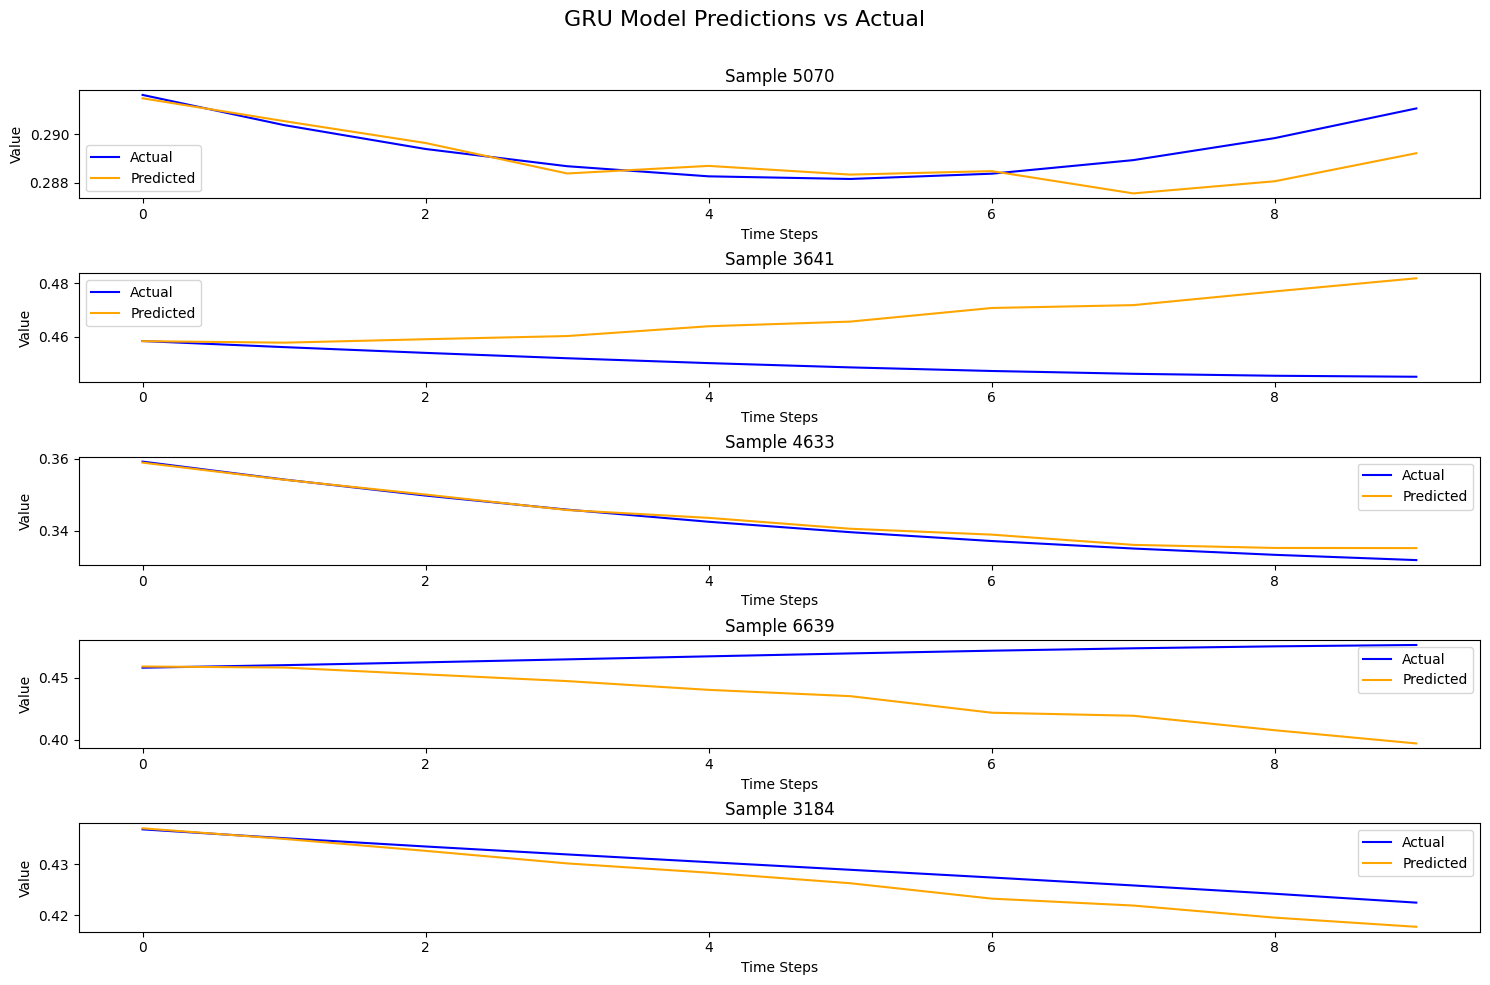

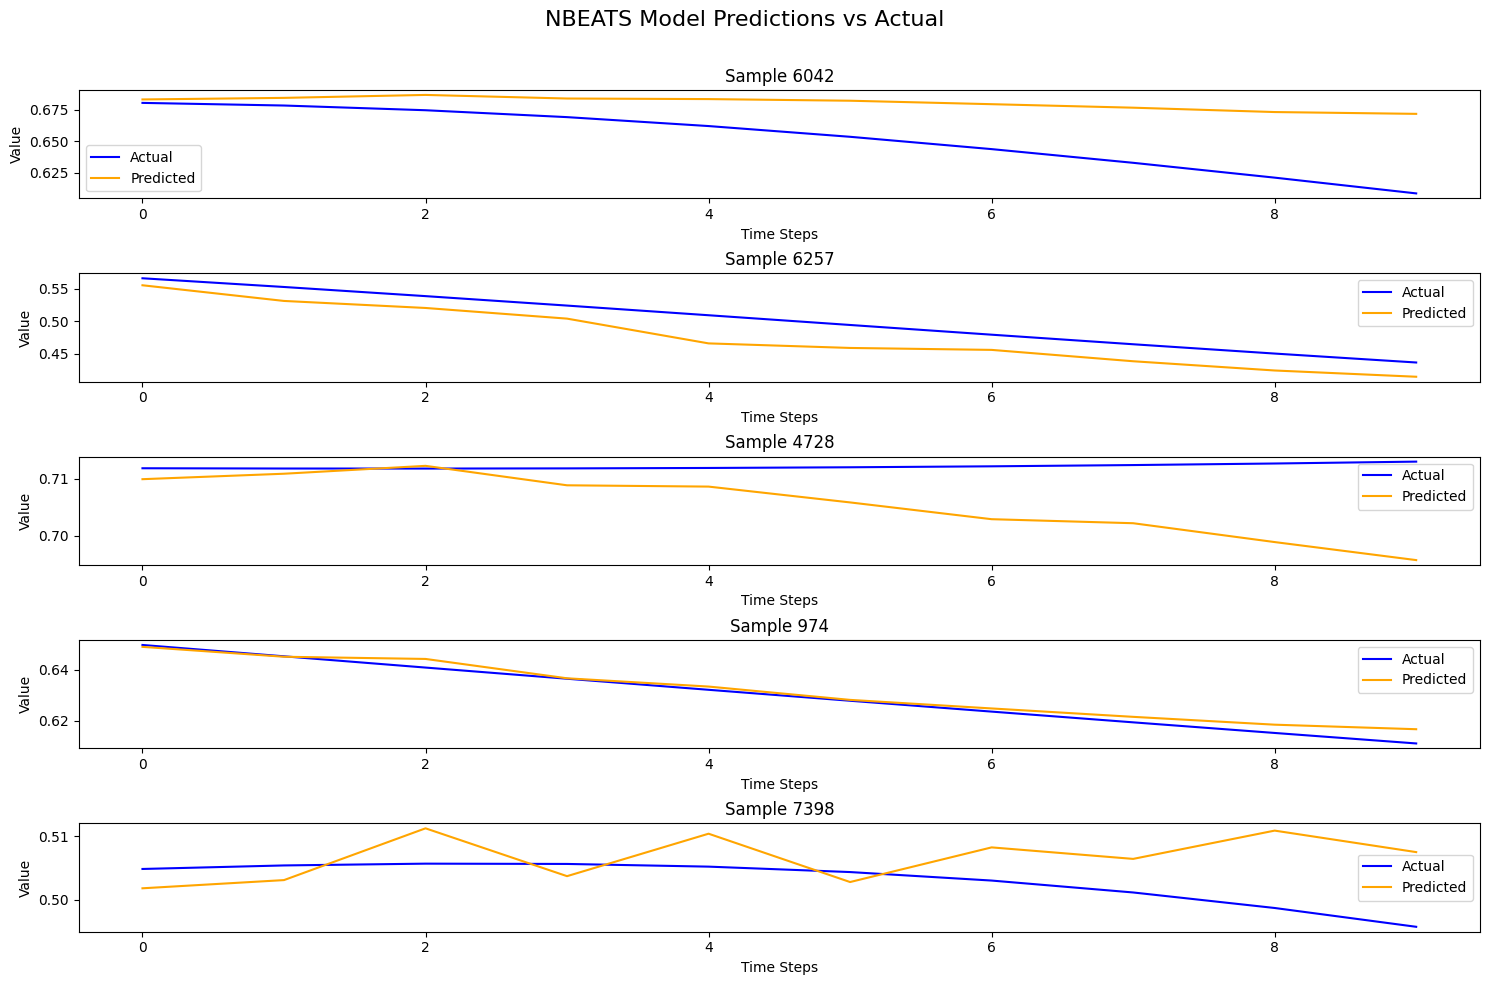

In [72]:
print("TESTTESTESTESTESTEST:", pred_all_GRU.shape, pred_all_NBEATS.shape)
pred_tf_gru = pred_all_GRU[:,:,0]
pred_tf_gru = tf.convert_to_tensor(pred_tf_gru, dtype=tf.float32)
pred_exog_gru = pred_all_GRU[:,:,1:]
pred_tf_nbeats = pred_all_NBEATS[:,:,0]
pred_tf_nbeats = tf.convert_to_tensor(pred_tf_nbeats, dtype=tf.float32)
pred_exog_nbeats = pred_all_NBEATS[:,:,1:]
#pred_tf_tft = pred_all_TFT[:,:,0]
#pred_tf_tft = tf.convert_to_tensor(pred_tf_tft, dtype=tf.float32)
#pred_exog_tft = pred_all_TFT[:,:,1:]
#pred_tf_nbeatsx = pred_all_NBEATSx[:,:,0]
#pred_tf_nbeatsx = tf.convert_to_tensor(pred_tf_nbeatsx, dtype=tf.float32)
#pred_exog_nbeatsx = pred_all_NBEATSx[:,:,1:]

#print(dataset.X_test_exog.shape[0], dataset.Y_test, pred_tf)
mean_smape, mean_rmse = forecast_metrics(dataset, pred_tf_gru)
print(
    f"gru model trained, with test sMAPE score {mean_smape:0.4f}; test RMSE score: {mean_rmse:0.4f}."
)
mean_smape, mean_rmse = forecast_metrics(dataset, pred_tf_nbeats)
print(
    f"nbeats model trained, with test sMAPE score {mean_smape:0.4f}; test RMSE score: {mean_rmse:0.4f}."
)
#mean_smape, mean_rmse = forecast_metrics(dataset, pred_tf_tft)
#print(
#    f"tft model trained, with test sMAPE score {mean_smape:0.4f}; test RMSE score: {mean_rmse:0.4f}."
#)
#mean_smape, mean_rmse = forecast_metrics(dataset, pred_tf_nbeatsx)
#print(
#    f"nbeatsx model trained, with test sMAPE score {mean_smape:0.4f}; test RMSE score: {mean_rmse:0.4f}."
#)
def plot_predictions(y_true, y_pred, name, title='Model Predictions vs Actual', num_samples=5):

    # Ensure y_true and y_pred are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Select a random sample of indices to plot
    indices = np.random.choice(y_true.shape[0], num_samples, replace=False)

    plt.figure(figsize=(15, 10))
    
    for i, idx in enumerate(indices):
        plt.subplot(num_samples, 1, i + 1)
        plt.plot(y_true[idx], label='Actual', color='blue')
        plt.plot(y_pred[idx], label='Predicted', color='orange')
        plt.title(f'Sample {idx + 1}')
        plt.xlabel('Time Steps')
        plt.ylabel('Value')
        plt.legend()
    
    plt.tight_layout()
    plt.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.9)  # Adjust the top to make room for the title
    plt.savefig(f"plot_predictions{name}.png")
    plt.show()

# Assuming you have your predictions and actual values
# pred_tf is the output from your model
# dataset.Y_test is the actual target values
# Reshape predictions if necessary
pred_tf_reshaped_gru = pred_tf_gru.numpy().reshape(-1, horizon)  # Adjust based on your output shape #.numpy()
pred_tf_reshaped_nbeats = pred_tf_nbeats.numpy().reshape(-1, horizon)  # Adjust based on your output shape #.numpy()
#pred_tf_reshaped_tft = pred_tf_tft.numpy().reshape(-1, horizon)  # Adjust based on your output shape #.numpy()
#pred_tf_reshaped_nbeatsx = pred_tf_nbeatsx.numpy().reshape(-1, horizon)  # Adjust based on your output shape #.numpy()

y_test_reshaped = dataset.Y_test.reshape(-1, horizon)  # Adjust based on your target shape
print("TEST", pred_tf_reshaped_gru.shape, pred_tf_reshaped_nbeats.shape)#, pred_tf_reshaped_tft.shape, pred_tf_reshaped_nbeatsx.shape, y_test_reshaped.shape)
# Call the plotting function
plot_predictions(y_test_reshaped, pred_tf_reshaped_gru, "gru", title='GRU Model Predictions vs Actual')
plot_predictions(y_test_reshaped, pred_tf_reshaped_nbeats, "nbeats", title='NBEATS Model Predictions vs Actual')
#plot_predictions(y_test_reshaped, pred_tf_reshaped_tft, "tft", title='TFT Model Predictions vs Actual')
#plot_predictions(y_test_reshaped, pred_tf_reshaped_nbeatsx, "nbeatsx", title='NBEATSx Model Predictions vs Actual')

#for i in range(dataset.X_test_exog.shape[0]):
#print(pred_tf)

In [73]:
pred_all = pred_all_NBEATS
pred_tf = pred_tf_nbeats

hyper_bound, hypo_bound = 180, 70
print(f"===========CF generation setup=============")
print(f"hyper bound value: {hyper_bound}, hypo bound: {hypo_bound}.")

#args = parser.parse_args("--dataset ohiot1dm --horizon 6 --back-horizon 24 --random-seed 32 --train-size 0.8 --test-group hyper".split())
event_labels = list()
for i in range(len(pred_tf)):
    scaler = dataset.scaler[dataset.reg_idxs[i]][TARGET_COL]
    Y_preds_original = scaler.inverse_transform(tf.reshape(pred_tf[i], (1, -1)).numpy())
    if np.any(Y_preds_original >= hyper_bound):
        event_labels.append("hyper")
    elif np.any(Y_preds_original <= hypo_bound):
        event_labels.append("hypo")
    else:
        event_labels.append("normal")
hyper_indices = np.argwhere(np.array(event_labels) == "hyper").reshape(-1)
hypo_indices = np.argwhere(np.array(event_labels) == "hypo").reshape(-1)

print(f"hyper_indices shape: {hyper_indices.shape}")
print(f"hypo_indices shape: {hypo_indices.shape}")

print("LSASLSLKDGNS", Y_preds_original)
#plot(orig_train, orig_test, Y_preds_original)

# use a subset of the test
rand_test_size = 100
print(args.test_group)
if args.test_group == "hyper":
    if len(hyper_indices) >= rand_test_size:
        print("if", hyper_indices)
        np.random.seed(RANDOM_STATE)
        rand_test_idx = np.random.choice(
            hyper_indices, rand_test_size, replace=False
        )
    else:
        print("else", hyper_indices)
        rand_test_idx = hyper_indices
elif args.test_group == "hypo":
    if len(hypo_indices) >= rand_test_size:
        np.random.seed(RANDOM_STATE)
        rand_test_idx = np.random.choice(
            hypo_indices, rand_test_size, replace=False
        )
    else:
        rand_test_idx = hypo_indices
else:
    rand_test_idx = np.arange(dataset.X_reg_exog.shape[0])

Exog_test = dataset.X_reg_exog[rand_test_idx]
Target_test = dataset.X_reg_target[rand_test_idx]

print("ET", Exog_test, Target_test)

print(
    f"Generating CFs for {len(rand_test_idx)} samples in total, for {args.test_group} test group..."
)

# loss calculation ==> min/max bounds
desired_max_lst, desired_min_lst = list(), list()
hist_inputs = list()

# define the desired center to reach in two hours (24 timesteps for OhioT1DM)
# then we need to cut the first 6 steps to generate the desired bounds
desired_steps = 24 if args.dataset == "ohiot1dm" else 20
if args.test_group == "hyper":
    desired_center_2h = hyper_bound - 10  # -10 for a fluctuating bound
elif args.test_group == "hypo":
    desired_center_2h = hypo_bound + 10  # +10 for a fluctuating bound
else:
    print(
        f"Group not identified: {args.test_group}, use a default center"
    )
    desired_center_2h = (hyper_bound + hypo_bound) / 2
#print(f"desired center {desired_center_2h} in {desired_steps} timesteps.")

for i in range(len(Exog_test)): #???Maybe join exog, target
    idx = dataset.reg_idxs[rand_test_idx[i]]
    scaler = dataset.scaler[idx]

    desired_center_scaled = scaler[TARGET_COL].transform(
        np.array(desired_center_2h).reshape(-1, 1)
    )[0][0]
    #print(
    #    f"desired_center: {desired_center_2h}; after scaling: {desired_center_scaled:0.4f}"
    #)
    # desired trend bounds: use the `center` parameter from the input sequence as the starting point
    desired_max_scaled, desired_min_scaled = generate_bounds(
        center=center,  # Use the parameters defined at the beginning of the script
        shift=desired_shift,
        desired_center=desired_center_scaled,
        poly_order=poly_order,
        horizon=horizon,
        fraction_std=fraction_std,
        input_series=np.transpose(Target_test[i,0]),
        desired_steps=desired_steps,
    )
    print("max", desired_max_scaled)
    # TODO: remove the ones that already satisfy the bounds here, OR afterwards?
    desired_max_lst.append(desired_max_scaled)
    desired_min_lst.append(desired_min_scaled)
    hist_inputs.append(dataset.historical_values[idx])
    
#for i in range(X_test.shape[0]):
#    max_bound = (
#        desired_max_lst[i] if desired_max_lst != None else self.MISSING_MAX_BOUND
#    )
#    min_bound = (
#        desired_min_lst[i] if desired_min_lst != None else self.MISSING_MIN_BOUND
#    )


===========CF generation setup=============
hyper bound value: 180, hypo bound: 70.
hyper_indices shape: (311,)
hypo_indices shape: (350,)
LSASLSLKDGNS [[119.24908  119.19762  119.35626  118.9423   118.82571  118.59612
  118.37399  118.199165 117.92511  117.9539  ]]
hyper
if [ 169  170  171  172  185  186  187  188  197  198  199  200  585  586
  587  588  589  727  745  771  772  773  774  775  776  989 1626 1736
 1737 1738 1805 1806 1807 1808 1809 1810 1901 1902 1905 2023 2024 2025
 2026 2027 2030 2032 2164 2165 2166 2197 2198 2199 2200 2371 2372 2373
 2395 2425 2426 2427 2460 2461 2462 2463 2464 2465 2466 2467 2528 2529
 2530 2531 2532 2534 2535 2540 2541 2543 2544 2570 2571 2572 2573 2574
 2603 2604 2605 2687 2688 2689 2690 2691 2692 2693 2705 2706 2745 2746
 2747 2748 2749 2750 2857 2858 2859 2966 2967 2968 2969 2970 2971 2990
 2991 2992 2993 2994 2995 2996 3026 3027 3028 3029 3030 3103 3104 3137
 3149 3150 3151 3152 3153 3154 3176 3177 3178 3179 3515 3516 3517 3690
 3691 3983 398

In [74]:
print(rand_test_idx)

[2750 4646 4368  775 7568 7859 4367 3153 7040 6862 4053 2372 7041 7674
 2996 3988 2030 3150 6601 2460 7569 7857 7670 7015 4454 7181 6753 2032
  771 7856  197 2540 4505 7012 3103 2687 1738 2990 4507 7419  587 6603
  772 7807 5903 2395 2466 4496 4456 2995 7176 7802  745 7673  585 7039
 7855 2858 2994 2969 7512  727 1737 7490 7858 7384  200 4499 7671 7800
 7032 6608 7961  588 7274  586 7013 7031 7504 7779 7957 3154 3178  172
 7268 1808 4055 2164 3026 3179  186 2691 7707 7962  989 2970 7178 4366
 2023 3516]


In [75]:
import numpy as np

class SimpleBaseline:
    def __init__(self, dataset, back_horizon, horizon, target_col):
        self.dataset = dataset
        self.back_horizon = back_horizon
        self.horizon = horizon
        self.target_col = target_col
    
    def predict(self):
        num_samples = self.dataset.X_reg_target.shape[0]
        preds = np.empty((num_samples, self.horizon))
        
        for i in range(num_samples):
            # Using the last back_horizon values as history
            history = self.dataset.X_reg_target[i, -self.back_horizon:, self.target_col]
            mean_value = np.mean(history)
            preds[i] = np.full(self.horizon, mean_value)
        
        return preds


In [76]:
baseline = SimpleBaseline(dataset, back_horizon=10, horizon=5, target_col=0)
baseline_predictions = baseline.predict()

print("Baseline predictions shape:", baseline_predictions.shape)
print(baseline_predictions[0])  # Inspect first prediction


Baseline predictions shape: (8020, 5)
[0.34976066 0.34976066 0.34976066 0.34976066 0.34976066]


In [77]:
import numpy as np
import tensorflow as tf
import statsmodels.api as sm

class TimeSeriesOptimizer:
    def __init__(self, method, dataset, pred_exog, desired_max_lst, desired_min_lst, pred_tf, rand_test_idx, back_horizon, horizon, target_col, change_cols, clip_ranges, hist_inputs):
        self.method = method  # 'sarimax', 'ols', 'gru', or 'nbeats'
        self.dataset = dataset
        self.pred_exog = pred_exog
        self.desired_max_lst = desired_max_lst
        self.desired_min_lst = desired_min_lst
        self.pred_tf = pred_tf
        self.rand_test_idx = rand_test_idx
        self.horizon = horizon
        self.back_horizon = back_horizon
        self.TARGET_COL = target_col
        self.CHANGE_COLS = change_cols
        self.learning_rate = 0.001

        self.clip_range_inputs = clip_ranges
        self.hist_value_inputs = hist_inputs
        
        self.targets = None
        self.orig_targets = None
        self.transformed_targets = None
        self.transformed_orig_targets = None
        self.transformed_exogs = None
        self.transformed_orig_exogs = None
        self.orig_exogs = None
        self.exogs = None
        self.losses = None
        self.model = None
        self.optimizer = None

        self._init_method()

    def _init_method(self):
        if self.method == 'sarimax':
            # No pretraining here, SARIMAX models trained per sample
            pass
        elif self.method == 'ols':
            # Similarly, OLS models trained per sample
            pass
        elif self.method == 'gru':
            self._init_gru_model()
        elif self.method == 'nbeats':
            self._init_nbeats_model()
        else:
            raise ValueError(f"Unknown method: {self.method}")

    def _init_gru_model(self):
        X = self.dataset.X_reg_exog
        y = self.dataset.X_reg_target[:, self.TARGET_COL]
        X_val = self.dataset.X_reg_val_exog
        y_val = self.dataset.X_reg_val_target[:, self.TARGET_COL]

        in_features = X.shape[2]
        self.model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.horizon, in_features)),
            tf.keras.layers.GRU(100, activation='tanh', return_sequences=True),
            tf.keras.layers.GRU(100, activation='tanh', return_sequences=False),
            tf.keras.layers.Dense(self.horizon, activation='linear'),
            tf.keras.layers.Reshape((self.horizon, 1))
        ])

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate,  epsilon=1e-07)
        self.model.compile(optimizer=self.optimizer, loss='mae')
        self.model.fit(X, y, epochs=200, batch_size=64,
                       validation_data=(X_val, y_val),
                       callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, restore_best_weights=True)])

    def _init_nbeats_model(self):
        #back_horizon = self.back_horizon
        horizon = self.horizon
        #n_features = self.dataset.X_reg_exog.shape[2]

        class NBeatsBlock(tf.keras.layers.Layer):
            def __init__(self, units, horizon):
                super().__init__()
                self.fc1 = tf.keras.layers.Dense(units, activation='relu')
                self.fc2 = tf.keras.layers.Dense(units, activation='relu')
                self.fc3 = tf.keras.layers.Dense(units, activation='relu')
                self.fc4 = tf.keras.layers.Dense(units, activation='relu')
                self.forecast = tf.keras.layers.Dense(horizon)

            def call(self, inputs):
                x = self.fc1(inputs)
                x = self.fc2(x)
                x = self.fc3(x)
                x = self.fc4(x)
                return self.forecast(x)

        class DifferentiableNBeats(tf.keras.Model):
            def __init__(self, horizon, units=128):
                super().__init__()
                self.flatten = tf.keras.layers.Flatten()
                self.block = NBeatsBlock(units, horizon)

            def call(self, x):
                x = self.flatten(x)
                return self.block(x)

        self.model = DifferentiableNBeats(horizon=self.horizon, units=128)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.model.compile(optimizer=self.optimizer, loss='mae')

        # Optionally fit here if you have X_train, y_train, etc.

    def compute_loss(self, max_bound, min_bound, pred):
        mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)
        return mse(max_bound, pred) + mse(min_bound, pred)

    def compute_gradient_finite_difference(self, model, X_e, max_bound, min_bound, epsilon=1e-4):
        # Used for SARIMAX and OLS only
        original_pred = None
        if self.method == 'sarimax':
            temp = X_e.numpy()
            pred = model.forecast(self.horizon, start_params=model.params, exog=temp)
            pred = tf.convert_to_tensor(pred, dtype=tf.float32)
            original_pred = pred
        elif self.method == 'ols':
            temp = X_e.numpy()
            pred = model.predict(temp)
            pred = tf.convert_to_tensor(pred, dtype=tf.float32)
            original_pred = pred

        original_loss = self.compute_loss(max_bound, min_bound, original_pred)

        gradients = np.zeros_like(X_e.numpy())
        for i in range(X_e.shape[0]):
            X_e_perturbed = X_e.numpy()
            X_e_perturbed[i] += epsilon

            if self.method == 'sarimax':
                pred_perturbed = model.forecast(self.horizon, start_params=model.params, exog=X_e_perturbed)
            elif self.method == 'ols':
                pred_perturbed = model.predict(X_e_perturbed)
            pred_perturbed = tf.convert_to_tensor(pred_perturbed, dtype=tf.float32)

            perturbed_loss = self.compute_loss(max_bound, min_bound, pred_perturbed)
            gradients[i] = (perturbed_loss.numpy() - original_loss.numpy()) / epsilon

        return gradients

    def optimize(self):
        length = len(self.desired_max_lst)
        self.targets = np.empty((length, self.horizon))
        self.orig_targets = np.empty((length, self.horizon))
        self.transformed_targets = np.empty((length, self.horizon))
        self.transformed_orig_targets = np.empty((length, self.horizon))
        self.transformed_exogs = np.empty((length, self.horizon, self.pred_exog.shape[2]))
        self.transformed_orig_exogs = np.empty((length, self.horizon, self.pred_exog.shape[2]))
        self.orig_exogs = np.empty((length, self.horizon, self.pred_exog.shape[2]))
        self.exogs = np.empty((length, self.horizon, self.pred_exog.shape[2]))
        self.losses = np.empty(length)

        for i in range(length):
            max_bound = self.desired_max_lst[i]
            min_bound = self.desired_min_lst[i]
            clip_ranges = self.clip_range_inputs[i] if self.clip_range_inputs else None
            #print(f"clip_ranges:{clip_ranges is not None}")
            hist_values = self.hist_value_inputs[i] if self.hist_value_inputs else None
            #print(f"hist_values:{hist_values is not None}")

            if self.method == 'sarimax':
                self._optimize_sarimax(i, max_bound, min_bound, clip_ranges, hist_values)
            elif self.method == 'ols':
                self._optimize_ols(i, max_bound, min_bound, clip_ranges, hist_values)
            elif self.method == 'gru':
                self._optimize_gru(i, max_bound, min_bound, clip_ranges, hist_values)
            elif self.method == 'nbeats':
                self._optimize_nbeats(i, max_bound, min_bound, clip_ranges, hist_values)
            else:
                raise ValueError(f"Unknown method: {self.method}")

    def _optimize_sarimax(self, i, max_bound, min_bound, clip_ranges, hist_values):
        # Extract exog and target
        X = self.dataset.X_reg_exog[i]
        y = self.dataset.X_reg_target[i][:, self.TARGET_COL]
        pred_exog_sample = self.pred_exog[self.rand_test_idx][i]

        for dim in range(self.dataset.X_reg_exog.shape[2]):
            if clip_ranges:
                clip_low, clip_high = clip_ranges[dim]
                grad_X_e = tf.Variable(
                    pred_exog_sample, #self.pred_exog[i],
                    dtype=tf.float32,
                    constraint=lambda x: tf.clip_by_value(x, clip_low, clip_high)
                )
            else:
                grad_X_e = tf.Variable(pred_exog_sample, dtype=tf.float32)  # shape should be (horizon, n_features)

        mod = sm.tsa.SARIMAX(endog=np.asarray(y), exog=np.asarray(X), order=(1, 0, 0))
        mod = mod.fit(disp=False)

        start_params = mod.params
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)

        #grad_X_e = tf.convert_to_tensor(self.pred_exog[i], dtype=tf.float32)
        #grad_X_e = tf.Variable(grad_X_e, dtype=tf.float32)
        #grad_X_e = tf.Variable(self.pred_exog[self.rand_test_idx][i], dtype=tf.float32)

        pred = mod.forecast(self.horizon, start_params=start_params, exog=grad_X_e.numpy())
        pred = tf.convert_to_tensor(pred, dtype=tf.float32)

        it = 0
        max_iter = 100
        while (tf.reduce_any(pred > max_bound) or tf.reduce_any(pred < min_bound)) and it < max_iter:
            gradients = self.compute_gradient_finite_difference(mod, grad_X_e, max_bound, min_bound)
            optimizer.apply_gradients([(tf.convert_to_tensor(gradients, dtype=tf.float32), grad_X_e)])

            pred = mod.forecast(self.horizon, start_params=start_params, exog=grad_X_e.numpy())
            pred = tf.convert_to_tensor(pred, dtype=tf.float32)

            it += 1

        scaler = self.dataset.scaler[self.dataset.reg_idxs[i]][self.TARGET_COL]
        predicted_transformed_target = scaler.inverse_transform(pred.numpy().reshape(-1, 1))
        orig_transformed_target = scaler.inverse_transform(self.pred_tf[i].numpy().reshape(-1, 1))
        transformed_exogs = []
        transformed_orig_exogs = []
        for j, col in enumerate(self.CHANGE_COLS):
            scaler = self.dataset.scaler[self.dataset.reg_idxs[i]][col]
            transformed = scaler.inverse_transform(grad_X_e.numpy()[:, j].reshape(-1, 1))
            transformed_orig = scaler.inverse_transform(self.pred_exog[i][:, j].reshape(-1, 1))
            transformed_exogs.append(transformed)
            transformed_orig_exogs.append(transformed_orig)
        predicted_transformed_exogs = np.hstack(transformed_exogs)
        predicted_transformed_orig_exogs = np.hstack(transformed_exogs)

        self.targets[i] = pred.numpy()
        self.orig_targets[i] = self.pred_tf[i]
        self.transformed_targets[i] = predicted_transformed_target.squeeze()
        self.transformed_orig_targets[i] = orig_transformed_target.squeeze()
        self.transformed_exogs[i] = predicted_transformed_exogs.squeeze()
        self.transformed_orig_exogs[i] = predicted_transformed_orig_exogs.squeeze()
        self.orig_exogs[i] = self.pred_exog[i]
        self.exogs[i] = grad_X_e.numpy().squeeze()
        self.losses[i] = self.compute_loss(max_bound, min_bound, pred).numpy()

    def _optimize_ols(self, i, max_bound, min_bound, clip_ranges, hist_values):
        X = self.dataset.X_reg_exog[i]
        y = self.dataset.X_reg_target[i][:, self.TARGET_COL]
        for dim in range(self.dataset.X_reg_exog.shape[2]):
            if clip_ranges:
                clip_low, clip_high = clip_ranges[dim]
                grad_X_e = tf.Variable(
                    self.pred_exog[i],
                    dtype=tf.float32,
                    constraint=lambda x: tf.clip_by_value(x, clip_low, clip_high)
                )
            else:
                grad_X_e = tf.Variable(self.pred_exog[i], dtype=tf.float32)  # shape should be (horizon, n_features)


        model = sm.OLS(y, X).fit()
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)

        #grad_X_e = tf.Variable(self.pred_exog[self.rand_test_idx][i], dtype=tf.float32)

        #grad_X_e = tf.convert_to_tensor(self.pred_exog[i], dtype=tf.float32)
        #grad_X_e = tf.Variable(grad_X_e, dtype=tf.float32)
        
        pred = model.predict(grad_X_e.numpy())
        pred = tf.convert_to_tensor(pred, dtype=tf.float32)

        it = 0
        max_iter = 100

        while (tf.reduce_any(pred > max_bound) or tf.reduce_any(pred < min_bound)) and it < max_iter:
            gradients = self.compute_gradient_finite_difference(model, grad_X_e, max_bound, min_bound)
            optimizer.apply_gradients([(tf.convert_to_tensor(gradients, dtype=tf.float32), grad_X_e)])

            pred = model.predict(grad_X_e.numpy())
            pred = tf.convert_to_tensor(pred, dtype=tf.float32)

            it += 1

        scaler = self.dataset.scaler[self.dataset.reg_idxs[i]][self.TARGET_COL]
        predicted_transformed_target = scaler.inverse_transform(pred.numpy().reshape(-1, 1))
        orig_transformed_target = scaler.inverse_transform(self.pred_tf[i].numpy().reshape(-1, 1))
        transformed_exogs = []
        transformed_orig_exogs = []
        for j, col in enumerate(self.CHANGE_COLS):
            scaler = self.dataset.scaler[self.dataset.reg_idxs[i]][col]
            transformed = scaler.inverse_transform(grad_X_e.numpy()[:, j].reshape(-1, 1))
            transformed_orig = scaler.inverse_transform(self.pred_exog[i][:, j].reshape(-1, 1))
            transformed_exogs.append(transformed)
            transformed_orig_exogs.append(transformed_orig)
        predicted_transformed_exogs = np.hstack(transformed_exogs)
        predicted_transformed_orig_exogs = np.hstack(transformed_exogs)
        
        self.targets[i] = pred.numpy()
        self.orig_targets[i] = self.pred_tf[i]
        self.orig_exogs[i] = self.pred_exog[i]
        self.transformed_targets[i] = predicted_transformed_target.squeeze()
        self.transformed_orig_targets[i] = orig_transformed_target.squeeze()
        self.transformed_exogs[i] = predicted_transformed_exogs.squeeze()
        self.transformed_orig_exogs[i] = predicted_transformed_orig_exogs.squeeze()
        self.exogs[i] = grad_X_e.numpy().squeeze()
        self.losses[i] = self.compute_loss(max_bound, min_bound, pred).numpy()

    def _optimize_gru(self, i, max_bound, min_bound, clip_ranges, hist_values):
        for dim in range(self.dataset.X_reg_exog.shape[2]):
            if clip_ranges:
                clip_low, clip_high = clip_ranges[dim]
                grad_X_e = tf.Variable(
                    self.pred_exog[i],
                    dtype=tf.float32,
                    constraint=lambda x: tf.clip_by_value(x, clip_low, clip_high)
                )
            else:
                grad_X_e = tf.Variable(self.pred_exog[i], dtype=tf.float32)  # shape should be (horizon, n_features)

        it = 0
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
        max_iter = 100
    
        pred = self.model(tf.expand_dims(grad_X_e, axis=0))[0, :, 0]  # (1, horizon, 1) -> (horizon,)
        loss = self.compute_loss(max_bound, min_bound, pred)
    
        while (tf.reduce_any(pred > max_bound) or tf.reduce_any(pred < min_bound)) and it < max_iter:
            with tf.GradientTape() as tape:
                pred = self.model(tf.expand_dims(grad_X_e, axis=0))[0, :, 0]
                loss = self.compute_loss(max_bound, min_bound, pred)
    
            gradients = tape.gradient(loss, grad_X_e)
            optimizer.apply_gradients([(gradients, grad_X_e)])
    
            it += 1
        
        scaler = self.dataset.scaler[self.dataset.reg_idxs[i]][self.TARGET_COL]
        predicted_transformed_target = scaler.inverse_transform(pred.numpy().reshape(-1, 1))
        orig_transformed_target = scaler.inverse_transform(self.pred_tf[i].numpy().reshape(-1, 1))
        transformed_exogs = []
        transformed_orig_exogs = []
        for j, col in enumerate(self.CHANGE_COLS):
            scaler = self.dataset.scaler[self.dataset.reg_idxs[i]][col]
            transformed = scaler.inverse_transform(grad_X_e.numpy()[:, j].reshape(-1, 1))
            transformed_orig = scaler.inverse_transform(self.pred_exog[i][:, j].reshape(-1, 1))
            transformed_exogs.append(transformed)
            transformed_orig_exogs.append(transformed_orig)
        predicted_transformed_exogs = np.hstack(transformed_exogs)
        predicted_transformed_orig_exogs = np.hstack(transformed_exogs)
        
        self.targets[i] = pred.numpy()
        self.orig_targets[i] = self.pred_tf[i]
        self.orig_exogs[i] = self.pred_exog[i]
        self.transformed_targets[i] = predicted_transformed_target.squeeze()
        self.transformed_orig_targets[i] = orig_transformed_target.squeeze()
        self.transformed_exogs[i] = predicted_transformed_exogs.squeeze()
        self.transformed_orig_exogs[i] = predicted_transformed_orig_exogs.squeeze()
        self.exogs[i] = grad_X_e.numpy().squeeze()
        self.losses[i] = loss.numpy()


    def _optimize_nbeats(self, i, max_bound, min_bound, clip_ranges, hist_values):
        for dim in range(self.dataset.X_reg_exog.shape[2]):
            if clip_ranges:
                clip_low, clip_high = clip_ranges[dim]
                grad_X_e = tf.Variable(
                    self.pred_exog[i],
                    dtype=tf.float32,
                    constraint=lambda x: tf.clip_by_value(x, clip_low, clip_high)
                )
            else:
                grad_X_e = tf.Variable(self.pred_exog[i], dtype=tf.float32)  # shape should be (horizon, n_features)

        #grad_X_e = tf.Variable(self.pred_exog[self.rand_test_idx][i], dtype=tf.float32)
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)

        it = 0
        max_iter = 100

        pred = self.model(tf.expand_dims(grad_X_e, axis=0))[0]
        loss = self.compute_loss(max_bound, min_bound, pred)

        while (tf.reduce_any(pred > max_bound) or tf.reduce_any(pred < min_bound)) and it < max_iter:
            with tf.GradientTape() as tape:
                pred = self.model(tf.expand_dims(grad_X_e, axis=0))[0]
                loss = self.compute_loss(max_bound, min_bound, pred)

            gradients = tape.gradient(loss, grad_X_e)
            optimizer.apply_gradients([(gradients, grad_X_e)])

            it += 1

        
        scaler = self.dataset.scaler[self.dataset.reg_idxs[i]][self.TARGET_COL]
        predicted_transformed_target = scaler.inverse_transform(pred.numpy().reshape(-1, 1))
        orig_transformed_target = scaler.inverse_transform(self.pred_tf[i].numpy().reshape(-1, 1))
        transformed_exogs = []
        transformed_orig_exogs = []
        for j, col in enumerate(self.CHANGE_COLS):
            scaler = self.dataset.scaler[self.dataset.reg_idxs[i]][col]
            transformed = scaler.inverse_transform(grad_X_e.numpy()[:, j].reshape(-1, 1))
            transformed_orig = scaler.inverse_transform(self.pred_exog[i][:, j].reshape(-1, 1))
            transformed_exogs.append(transformed)
            transformed_orig_exogs.append(transformed_orig)
        predicted_transformed_exogs = np.hstack(transformed_exogs)
        predicted_transformed_orig_exogs = np.hstack(transformed_exogs)

        self.targets[i] = pred.numpy()
        self.orig_targets[i] = self.pred_tf[i]
        self.orig_exogs[i] = self.pred_exog[i]
        self.transformed_targets[i] = predicted_transformed_target.squeeze()
        self.transformed_orig_targets[i] = orig_transformed_target.squeeze()
        self.transformed_exogs[i] = predicted_transformed_exogs.squeeze()
        self.transformed_orig_exogs[i] = predicted_transformed_orig_exogs.squeeze()
        self.exogs[i] = grad_X_e.numpy().squeeze()
        self.losses[i] = loss.numpy()


In [78]:
X_test = np.concatenate((Target_test, Exog_test), axis=2)
pred_exog = pred_exog_nbeats
clip_ranges = [[[0.0, 1.0]] * 5] * len(X_test)

In [79]:
#print(pred_exog, pred_exog.shape)
opt = TimeSeriesOptimizer(method='sarimax', dataset=dataset, pred_exog=pred_exog, desired_max_lst=desired_max_lst, desired_min_lst=desired_min_lst, pred_tf=pred_tf, rand_test_idx=rand_test_idx, back_horizon=back_horizon, horizon=horizon, target_col=TARGET_COL, change_cols=CHANGE_COLS, clip_ranges=clip_ranges, hist_inputs=hist_inputs)
opt.optimize()
targets_sarimax = opt.targets
orig_targets_sarimax = opt.orig_targets
exogs_sarimax = opt.exogs
orig_exogs_sarimax = opt.orig_exogs
losses_sarimax = opt.losses
transformed_targets_sarimax = opt.transformed_targets
transformed_exogs_sarimax = opt.transformed_exogs
transformed_orig_targets_sarimax = opt.transformed_orig_targets
transformed_orig_exogs_sarimax = opt.transformed_orig_exogs
print(opt.transformed_targets.shape, opt.transformed_exogs.shape)

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keywor

(100, 10) (100, 10, 2)


In [57]:
print(opt.transformed_targets.shape, opt.transformed_exogs.shape, opt.transformed_orig_targets.shape, opt.transformed_orig_exogs.shape)

(100, 10) (100, 10, 2) (100, 10) (100, 10, 2)


In [58]:

opt = TimeSeriesOptimizer(method='gru', dataset=dataset, pred_exog=pred_exog, desired_max_lst=desired_max_lst, desired_min_lst=desired_min_lst, pred_tf=pred_tf, rand_test_idx=rand_test_idx, back_horizon=back_horizon, horizon=horizon, target_col=TARGET_COL, change_cols=CHANGE_COLS, clip_ranges=clip_ranges, hist_inputs=hist_inputs)
opt.optimize()
targets_gru = opt.targets
orig_targets_gru = opt.orig_targets
exogs_gru = opt.exogs
orig_exogs_gru = opt.orig_exogs
losses_gru = opt.losses
transformed_targets_gru = opt.transformed_targets
transformed_exogs_gru = opt.transformed_exogs
transformed_orig_targets_gru = opt.transformed_orig_targets
transformed_orig_exogs_gru = opt.transformed_orig_exogs

Epoch 1/200


2025-07-12 16:11:16.304463: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}


125/126 [============================>.] - ETA: 0s - loss: 0.1573

2025-07-12 16:11:30.461097: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}


126/126 [==============================] - 18s 67ms/step - loss: 0.1572 - val_loss: 0.1381
Epoch 2/200
126/126 [==============================] - 7s 55ms/step - loss: 0.1394 - val_loss: 0.1383
Epoch 3/200
126/126 [==============================] - 9s 75ms/step - loss: 0.1406 - val_loss: 0.1387
Epoch 4/200
126/126 [==============================] - 8s 63ms/step - loss: 0.1395 - val_loss: 0.1381
Epoch 5/200
126/126 [==============================] - 8s 62ms/step - loss: 0.1385 - val_loss: 0.1381
Epoch 6/200
126/126 [==============================] - 8s 60ms/step - loss: 0.1394 - val_loss: 0.1382
Epoch 7/200
126/126 [==============================] - 7s 59ms/step - loss: 0.1390 - val_loss: 0.1387
Epoch 8/200
126/126 [==============================] - 8s 62ms/step - loss: 0.1388 - val_loss: 0.1386
Epoch 9/200
126/126 [==============================] - 7s 59ms/step - loss: 0.1389 - val_loss: 0.1381
Epoch 10/200
126/126 [==============================] - 8s 64ms/step - loss: 0.1389 - val_los

In [59]:
print(targets_gru, orig_targets_gru)

[[0.40126404 0.39991415 0.40227041 0.40146726 0.40309572 0.40189222
  0.39850578 0.40474421 0.40180334 0.40185291]
 [0.40126404 0.39991415 0.40227041 0.40146726 0.40309572 0.40189222
  0.39850578 0.40474421 0.40180334 0.40185291]
 [0.40126404 0.39991415 0.40227041 0.40146726 0.40309572 0.40189222
  0.39850578 0.40474421 0.40180334 0.40185291]
 [0.40126404 0.39991415 0.40227041 0.40146726 0.40309572 0.40189222
  0.39850578 0.40474421 0.40180334 0.40185291]
 [0.40126404 0.39991415 0.40227041 0.40146726 0.40309572 0.40189222
  0.39850578 0.40474421 0.40180334 0.40185291]
 [0.40126404 0.39991415 0.40227041 0.40146726 0.40309572 0.40189222
  0.39850578 0.40474421 0.40180334 0.40185291]
 [0.40126404 0.39991415 0.40227041 0.40146726 0.40309572 0.40189222
  0.39850578 0.40474421 0.40180334 0.40185291]
 [0.40126404 0.39991415 0.40227041 0.40146726 0.40309572 0.40189222
  0.39850578 0.40474421 0.40180334 0.40185291]
 [0.40126404 0.39991415 0.40227041 0.40146726 0.40309572 0.40189222
  0.39850578

In [60]:
opt = TimeSeriesOptimizer(method='ols', dataset=dataset, pred_exog=pred_exog, desired_max_lst=desired_max_lst, desired_min_lst=desired_min_lst, pred_tf=pred_tf, rand_test_idx=rand_test_idx, back_horizon=back_horizon, horizon=horizon, target_col=TARGET_COL, change_cols=CHANGE_COLS, clip_ranges=clip_ranges, hist_inputs=hist_inputs)
opt.optimize()
targets_ols = opt.targets
orig_targets_ols = opt.orig_targets
exogs_ols = opt.exogs
orig_exogs_ols = opt.orig_exogs
losses_ols = opt.losses
transformed_targets_ols = opt.transformed_targets
transformed_exogs_ols = opt.transformed_exogs
transformed_orig_targets_gru = opt.transformed_orig_targets
transformed_orig_exogs_gru = opt.transformed_orig_exogs

In [61]:
opt = TimeSeriesOptimizer(method='nbeats', dataset=dataset, pred_exog=pred_exog, desired_max_lst=desired_max_lst, desired_min_lst=desired_min_lst, pred_tf=pred_tf, rand_test_idx=rand_test_idx, back_horizon=back_horizon, horizon=horizon, target_col=TARGET_COL, change_cols=CHANGE_COLS, clip_ranges=clip_ranges, hist_inputs=hist_inputs)
opt.optimize()
targets_nbeats = opt.targets
orig_targets_nbeats = opt.orig_targets
exogs_nbeats = opt.exogs
orig_exogs_nbeats = opt.orig_exogs
losses_nbeats = opt.losses
transformed_targets_nbeats = opt.transformed_targets
transformed_exogs_nbeats = opt.transformed_exogs
transformed_orig_targets_gru = opt.transformed_orig_targets
transformed_orig_exogs_gru = opt.transformed_orig_exogs

In [62]:
# Prepare new arrays to hold the inverse-transformed values

numpy_desired_min = np.array(desired_min_lst)
numpy_desired_max = np.array(desired_max_lst)

inv_desired_min = np.empty_like(numpy_desired_min)
inv_desired_max = np.empty_like(numpy_desired_max)

for i in range(len(numpy_desired_min)):
    scaler = dataset.scaler[dataset.reg_idxs[i]][TARGET_COL]

    # Flatten [time, features] to [time * features] or [time, features]
    min_flat = numpy_desired_min[i].reshape(-1, numpy_desired_min.shape[-1])
    max_flat = numpy_desired_max[i].reshape(-1, numpy_desired_max.shape[-1])

    # Inverse transform
    inv_min_flat = scaler.inverse_transform(min_flat)
    inv_max_flat = scaler.inverse_transform(max_flat)

    # Reshape back to original [time, features] and assign
    inv_desired_min[i] = inv_min_flat.reshape(numpy_desired_min.shape[1], numpy_desired_min.shape[2])
    inv_desired_max[i] = inv_max_flat.reshape(numpy_desired_max.shape[1], numpy_desired_max.shape[2])

# Overwrite original arrays
numpy_desired_min = inv_desired_min
numpy_desired_max = inv_desired_max

print(numpy_desired_min, numpy_desired_max)


[[[175.17470663]
  [174.59198109]
  [174.00925556]
  [173.42653003]
  [172.84380449]
  [172.26107896]
  [171.67835342]
  [171.09562789]
  [170.51290236]
  [169.93017682]]

 [[185.76265442]
  [184.51405366]
  [183.26545291]
  [182.01685215]
  [180.76825139]
  [179.51965063]
  [178.27104987]
  [177.02244912]
  [175.77384836]
  [174.5252476 ]]

 [[180.34407723]
  [179.24356696]
  [178.14305668]
  [177.0425464 ]
  [175.94203613]
  [174.84152585]
  [173.74101558]
  [172.6405053 ]
  [171.53999502]
  [170.43948475]]

 [[168.10566624]
  [167.26309846]
  [166.42053068]
  [165.5779629 ]
  [164.73539512]
  [163.89282733]
  [163.05025955]
  [162.20769177]
  [161.36512399]
  [160.52255621]]

 [[149.80335275]
  [149.12396073]
  [148.44456871]
  [147.76517668]
  [147.08578466]
  [146.40639264]
  [145.72700062]
  [145.04760859]
  [144.36821657]
  [143.68882455]]

 [[165.06094151]
  [164.78543182]
  [164.50992212]
  [164.23441242]
  [163.95890272]
  [163.68339303]
  [163.40788333]
  [163.13237363]
  [1

In [63]:
print("orig_targets:", orig_targets_gru)
print("pred_targets:", targets_gru)
print("desired_min:", numpy_desired_min.shape)
print("desired_max:", numpy_desired_max.shape)

orig_targets: [[0.3601808  0.3561227  0.35302731 0.35075852 0.34805462 0.34737805
  0.34458983 0.34560099 0.34682044 0.34595212]
 [0.34265673 0.34179804 0.34260583 0.34211573 0.34060922 0.34162048
  0.34061247 0.34081534 0.34286523 0.34183714]
 [0.35173634 0.35210854 0.35388777 0.35562667 0.35507795 0.35688713
  0.35646537 0.35832959 0.35996354 0.359804  ]
 [0.35801941 0.35606977 0.35556996 0.35452256 0.3524859  0.3521224
  0.34926727 0.35027933 0.34809685 0.34745783]
 [0.35590655 0.35590574 0.35758454 0.35864544 0.35887221 0.36059368
  0.36155638 0.36374032 0.36526215 0.36714253]
 [0.40044931 0.40665779 0.41276234 0.41898707 0.42334911 0.42888173
  0.43379608 0.43850261 0.44334245 0.44691962]
 [0.436382   0.43590692 0.43585575 0.43502089 0.43191364 0.4299747
  0.4263849  0.4254193  0.42263556 0.41969153]
 [0.42900103 0.42761281 0.42750084 0.42622367 0.42483476 0.42486596
  0.42387626 0.42566761 0.42500082 0.42530847]
 [0.45200211 0.45564786 0.46009237 0.46496299 0.46786577 0.47216755


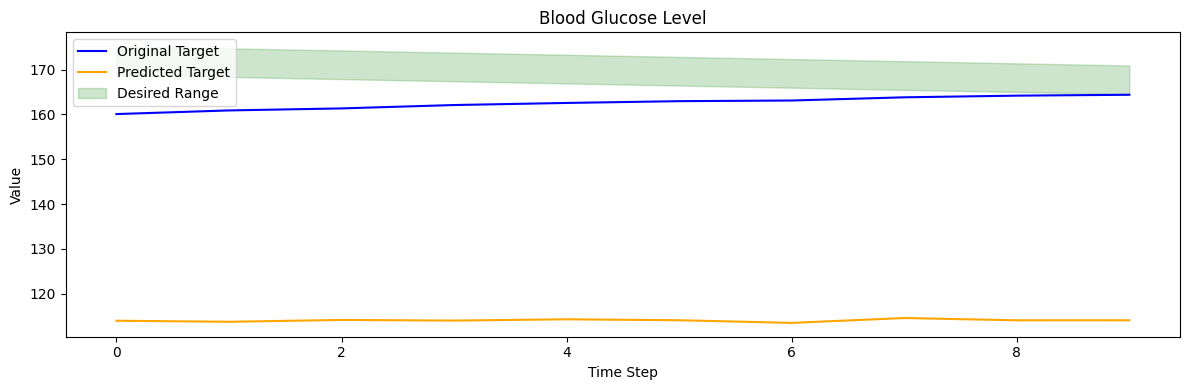

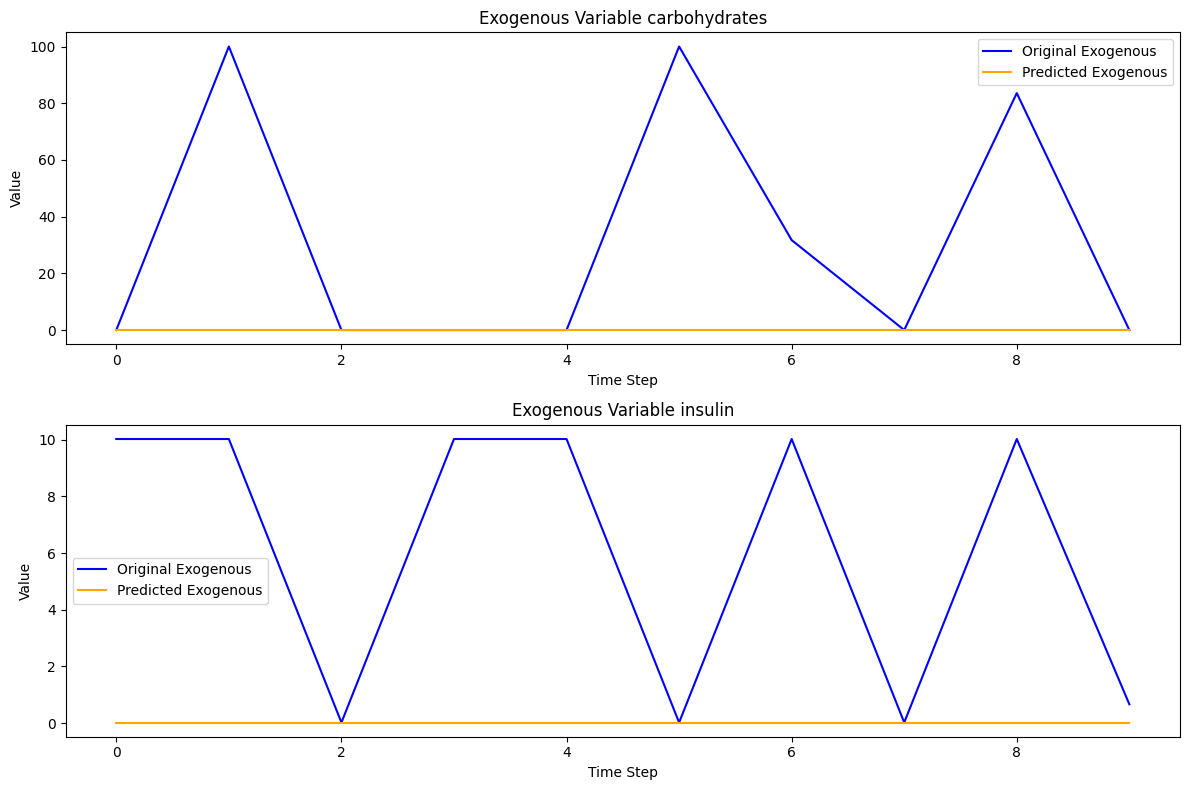

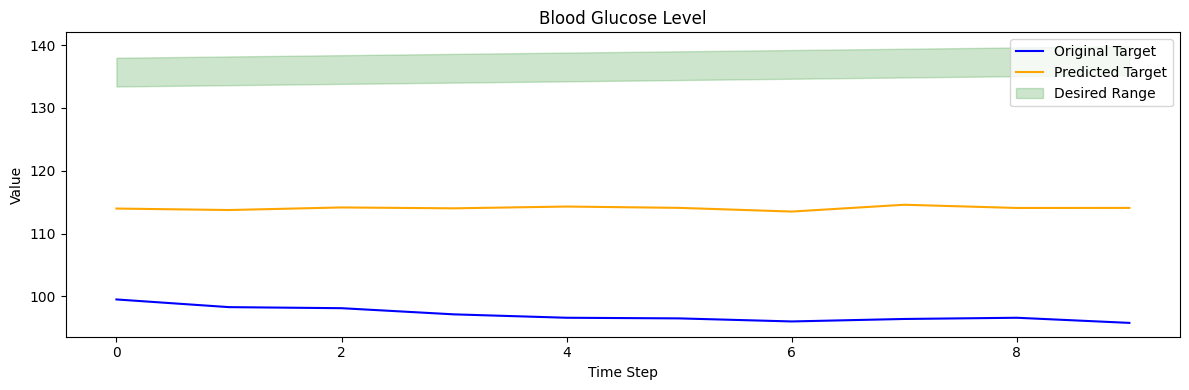

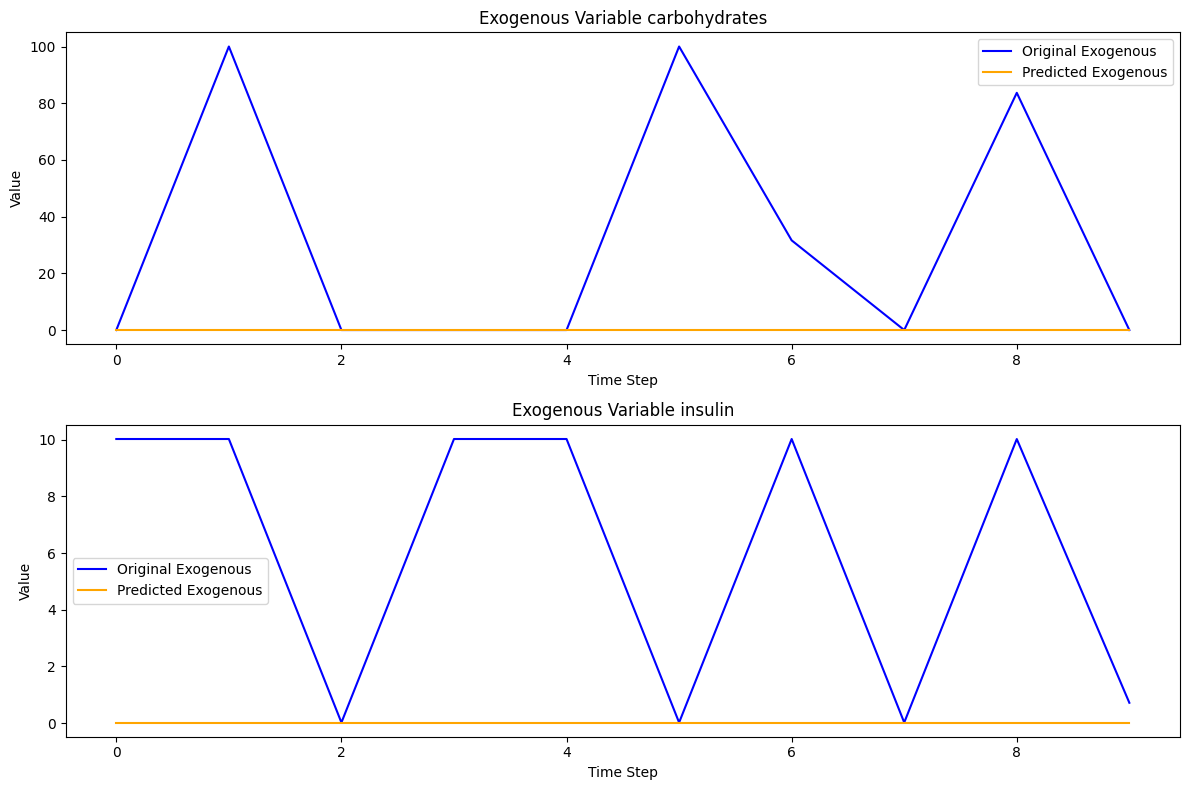

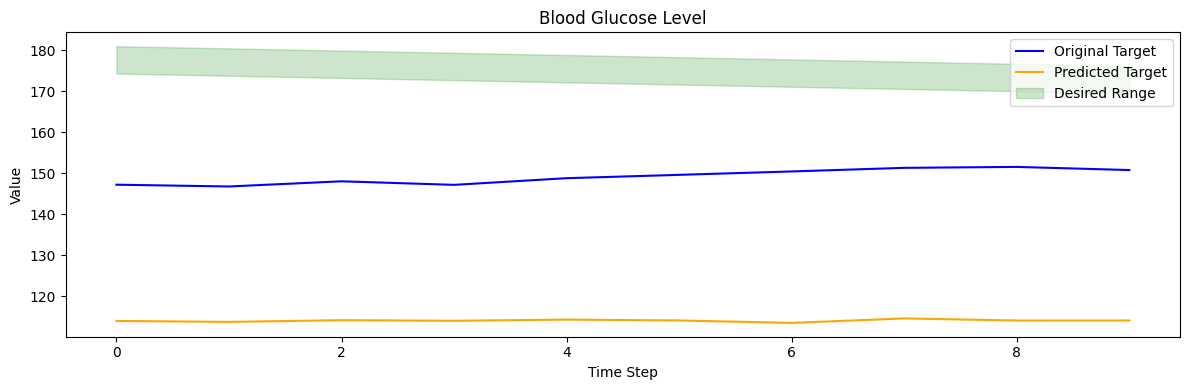

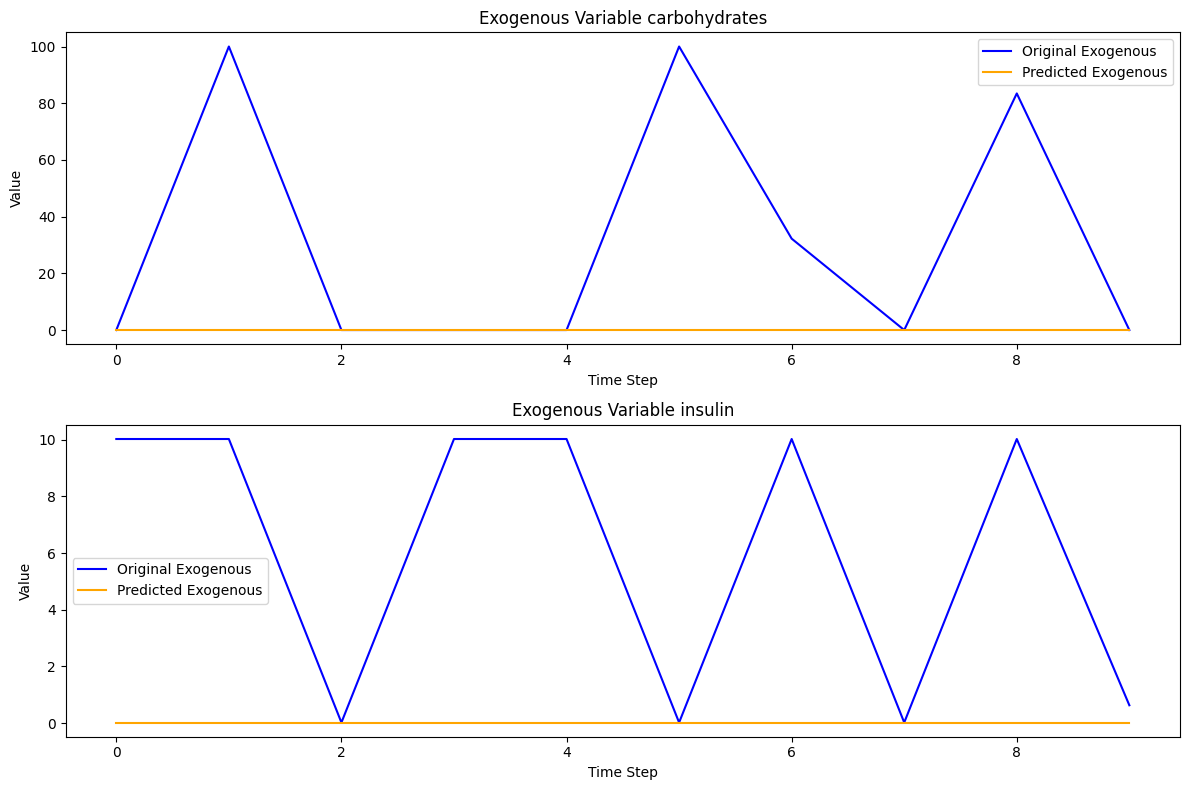

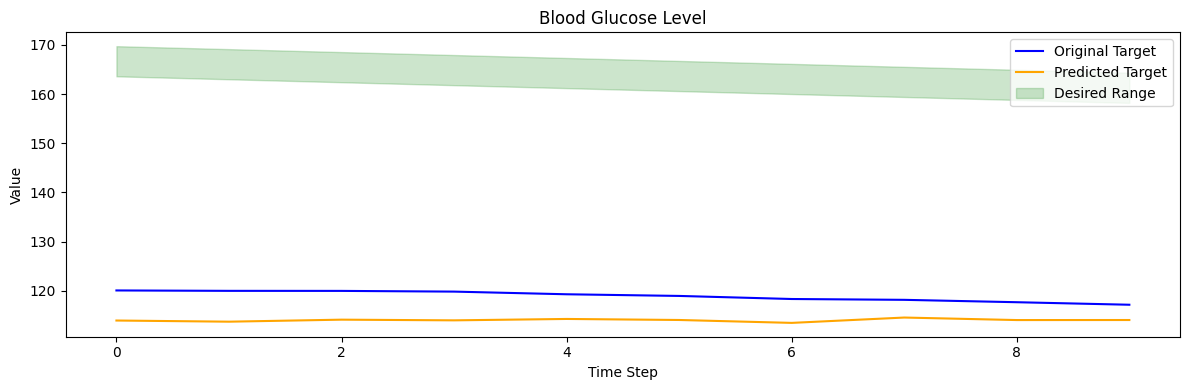

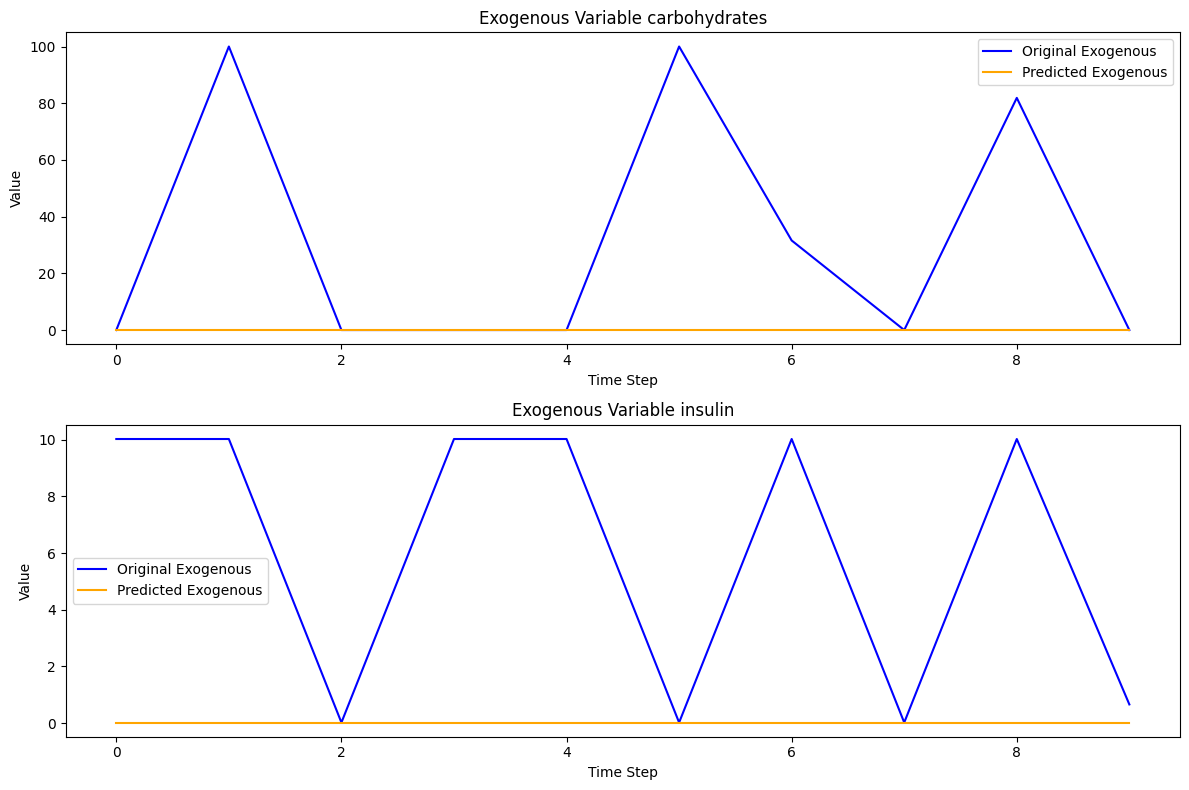

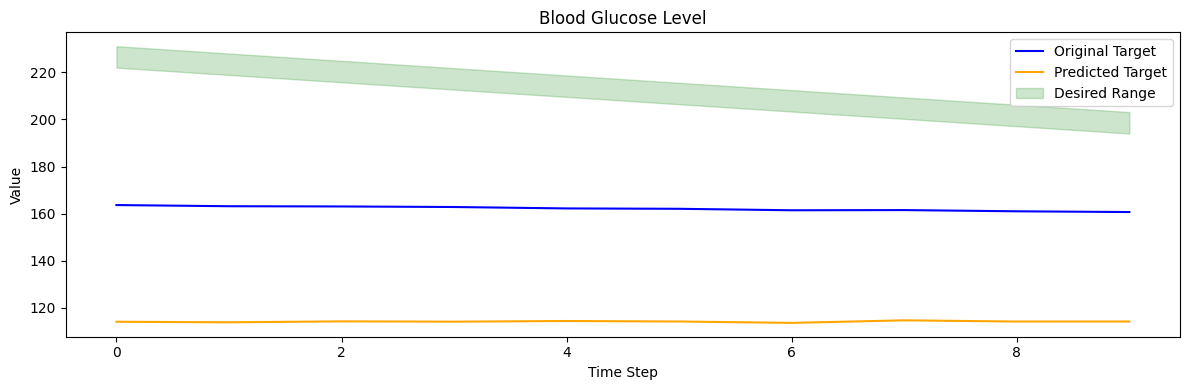

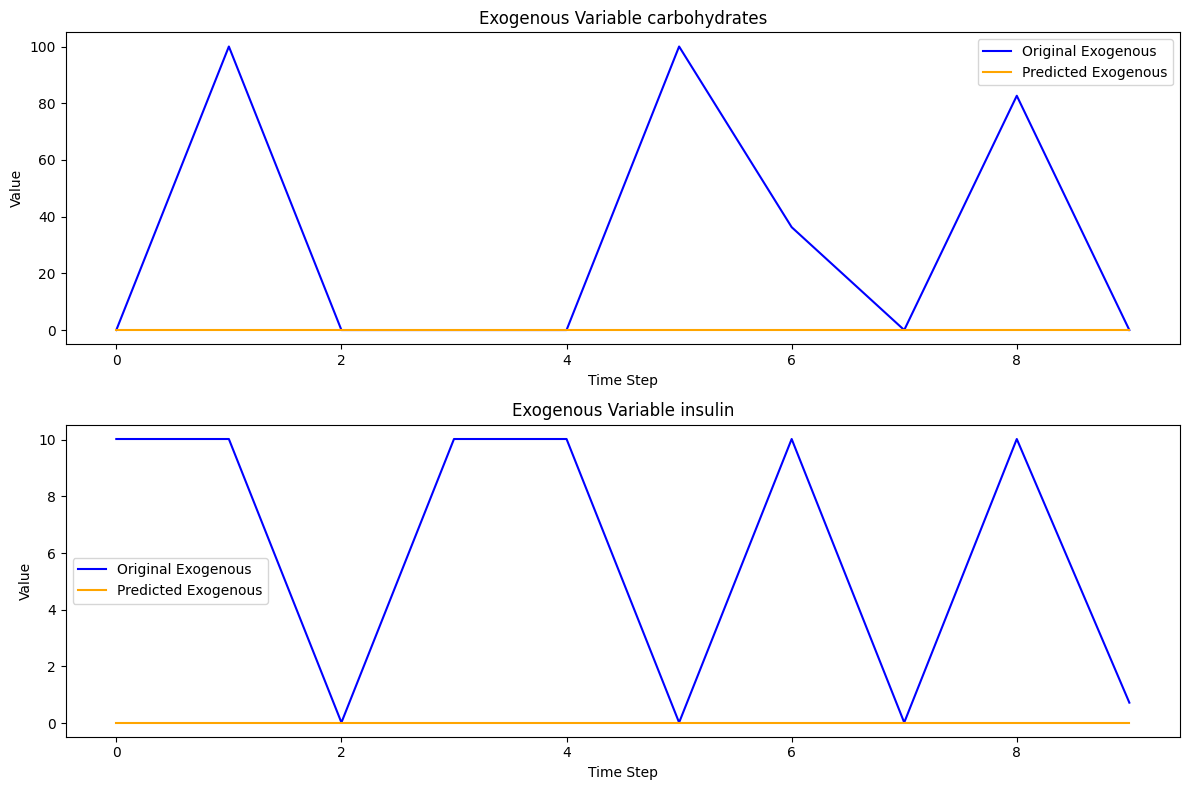

In [64]:

# Choose a sample index
sample_idx = random.sample(range(0, 100), 5)
#sample_idx = 58
for sam in sample_idx:
    time_steps = np.arange(transformed_orig_targets_gru.shape[1])
    
    # Extract time series
    orig_targets = transformed_orig_targets_gru[sam]
    pred_targets = transformed_targets_gru[sam]
    orig_exogs = transformed_orig_exogs_gru[sam]
    pred_exogs = transformed_exogs_gru[sam]
    
    # Reshape targets if necessary
    if orig_targets.ndim == 1:
        orig_targets = orig_targets[:, np.newaxis]
    if pred_targets.ndim == 1:
        pred_targets = pred_targets[:, np.newaxis]
    if numpy_desired_min.ndim == 2:
        numpy_desired_min = numpy_desired_min[:, :, np.newaxis]
    if numpy_desired_max.ndim == 2:
        numpy_desired_max = numpy_desired_max[:, :, np.newaxis]
    
    num_target_vars = orig_targets.shape[-1]
    
        
    # Plot Targets
    plt.figure(figsize=(12, 4 * num_target_vars))
    for i in range(num_target_vars):
        plt.subplot(num_target_vars, 1, i + 1)
        plt.plot(time_steps, orig_targets[:, i], label='Original Target', color='blue')
        plt.plot(time_steps, pred_targets[:, i], label='Predicted Target', color='orange')
        plt.fill_between(
            time_steps,
            numpy_desired_min[sam, :, i],
            numpy_desired_max[sam, :, i],
            color='green',
            alpha=0.2,
            label='Desired Range' if i == 0 else None
        )
        plt.title(f"Blood Glucose Level")
        plt.xlabel("Time Step")
        plt.ylabel("Value")
        plt.legend()
    plt.tight_layout()
    plt.savefig(f"BG_gru_sim_6_24_{sam}.png")
    plt.show()
    
    if args.dataset == "ohiot1dm":
        labels = ["basal insulin", "bolus insulin", "carbohydrates", "exercise intensity"]
        num_exog_vars = 4
    elif args.dataset == "simulated":
        labels = ["carbohydrates", "insulin"]
        num_exog_vars = 2
    else:
        labels = None
        num_exog_vars = orig_exogs.shape[-1]
    # Plot Exogenous Variables
    plt.figure(figsize=(12, 4 * num_exog_vars))
    for i in range(num_exog_vars):
        plt.subplot(num_exog_vars, 1, i + 1)
        plt.plot(time_steps, orig_exogs[:, i], label='Original Exogenous', color='blue')
        plt.plot(time_steps, pred_exogs[:, i], label='Predicted Exogenous', color='orange')
        plt.title(f"Exogenous Variable {labels[i]}")
        plt.xlabel("Time Step")
        plt.ylabel("Value")
        plt.legend()
    plt.tight_layout()
    plt.savefig(f"exogenous_gru_sim_6_24_{sam}.png")
    plt.show()


In [65]:
import numpy as np

# Assuming orig_targets and pred_targets are numpy arrays of shape (num_samples, timesteps, 1)
orig_flat = orig_targets.squeeze(-1)  # (num_orig_samples, timesteps)
pred_flat = pred_targets.squeeze(-1)  # (num_pred_samples, timesteps)

num_orig = orig_flat.shape[0]
num_pred = pred_flat.shape[0]

# Compute distance matrix (num_orig x num_pred)
dist_matrix = np.zeros((num_orig, num_pred))

for i in range(num_orig):
    for j in range(num_pred):
        dist_matrix[i, j] = np.linalg.norm(orig_flat[i] - pred_flat[j])

# Flatten the distance matrix and get indices of the 5 smallest distances
flat_indices = np.argpartition(dist_matrix.flatten(), 5)[:5]

# Convert flattened indices back to 2D indices
closest_pairs = [divmod(idx, num_pred) for idx in flat_indices]
closest_distances = [dist_matrix[i, j] for i, j in closest_pairs]

for rank, ((i, j), dist) in enumerate(sorted(zip(closest_pairs, closest_distances), key=lambda x: x[1]), 1):
    print(f"Rank {rank}: Orig sample {i} and Pred sample {j} with distance {dist:.4f}")

print(closest_pairs)

Rank 1: Orig sample 9 and Pred sample 7 with distance 46.0433
Rank 2: Orig sample 9 and Pred sample 4 with distance 46.3301
Rank 3: Orig sample 8 and Pred sample 7 with distance 46.3598
Rank 4: Orig sample 9 and Pred sample 2 with distance 46.4737
Rank 5: Orig sample 9 and Pred sample 5 with distance 46.5396
[(9, 7), (9, 4), (8, 7), (9, 2), (9, 5)]


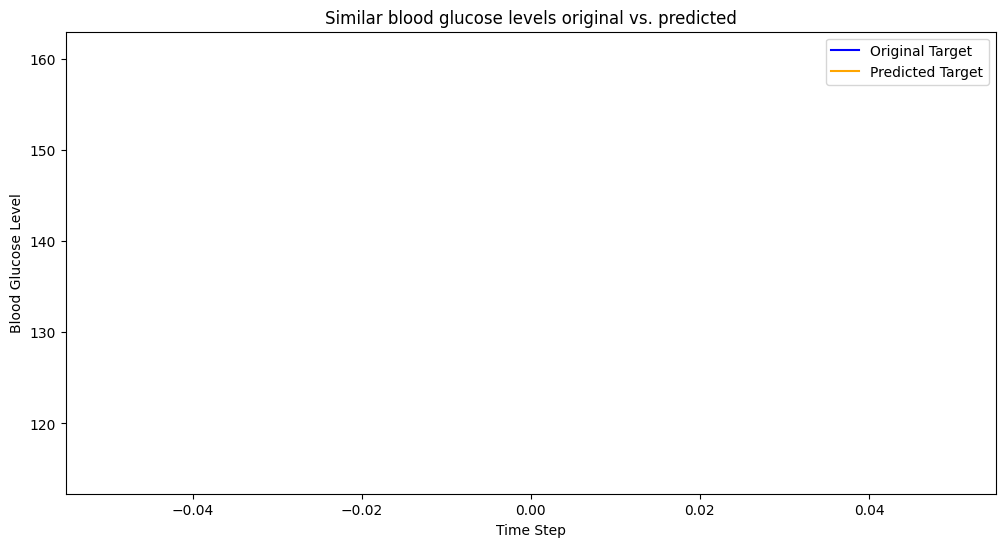

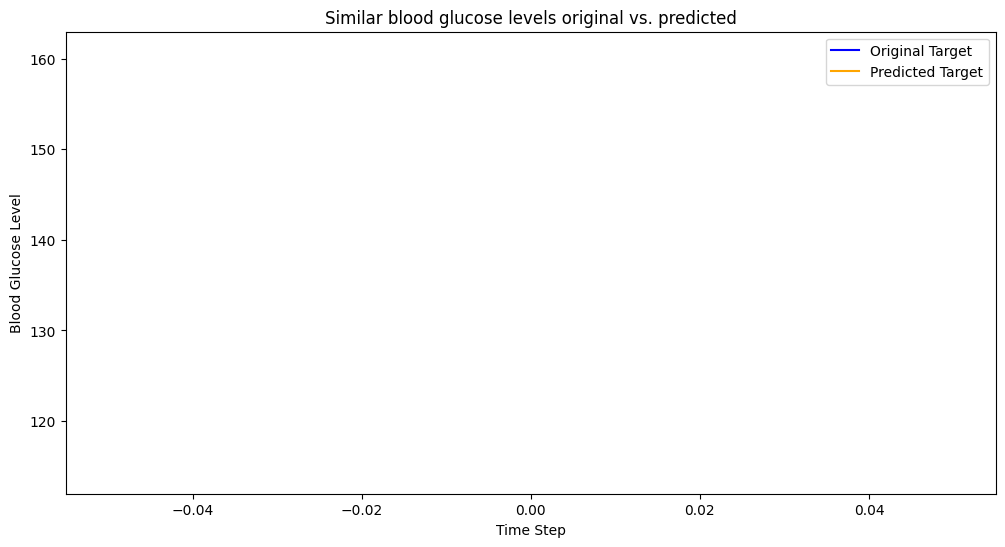

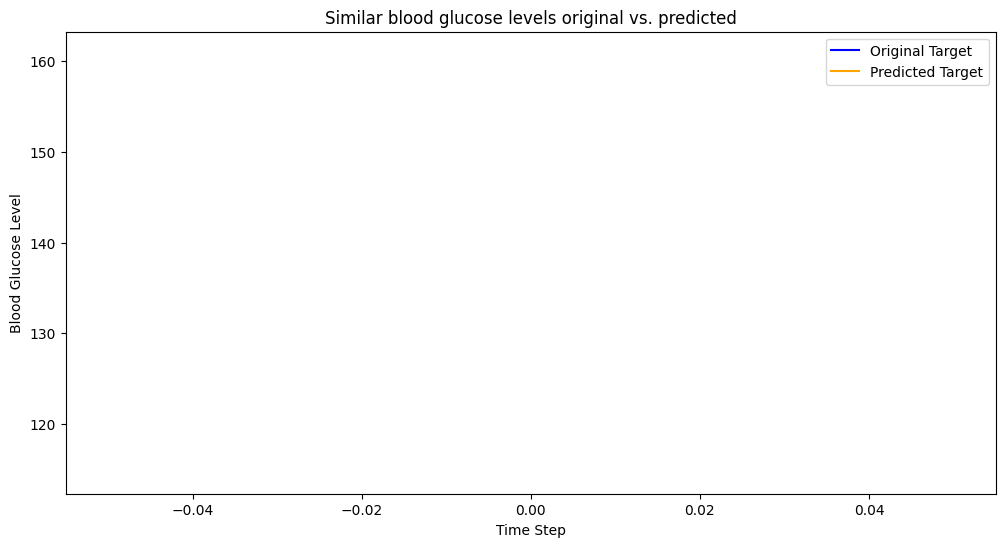

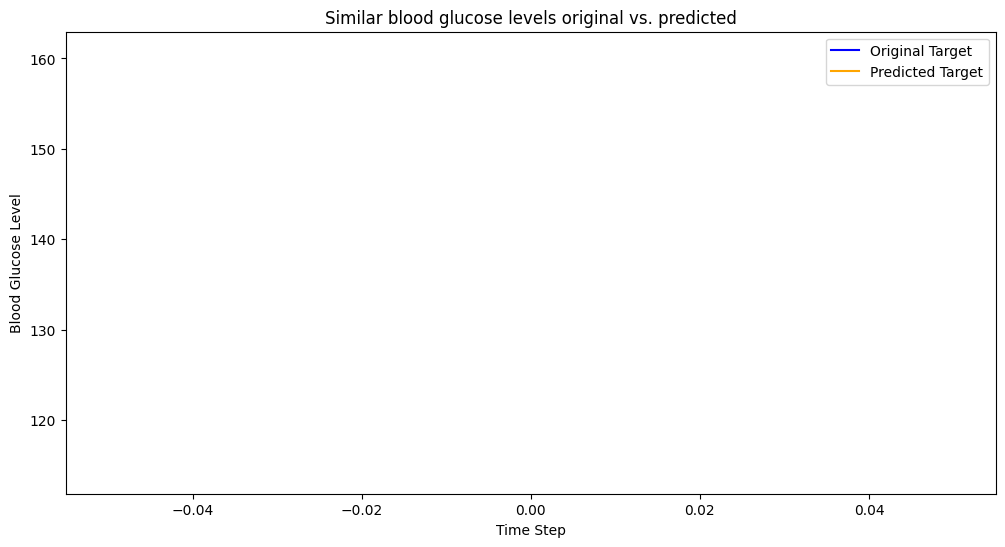

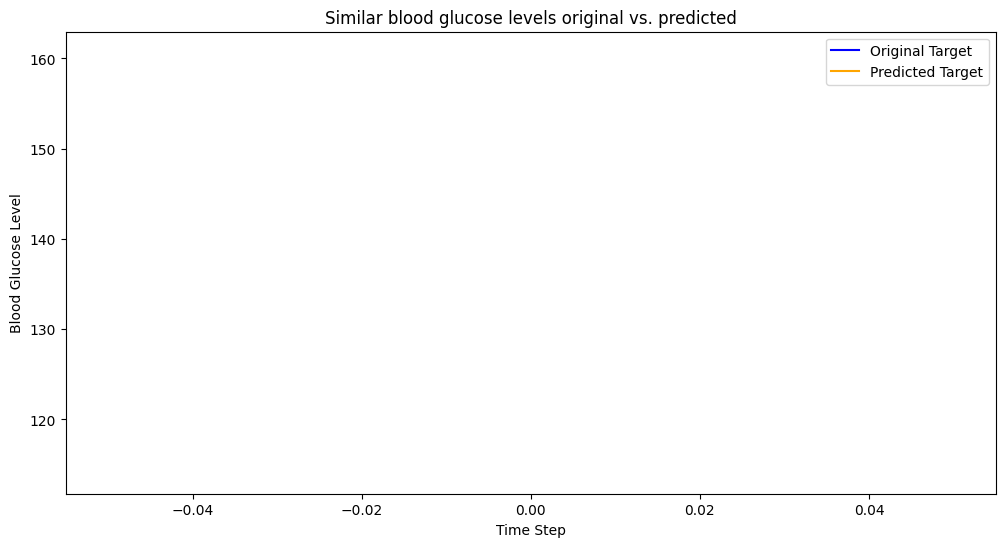

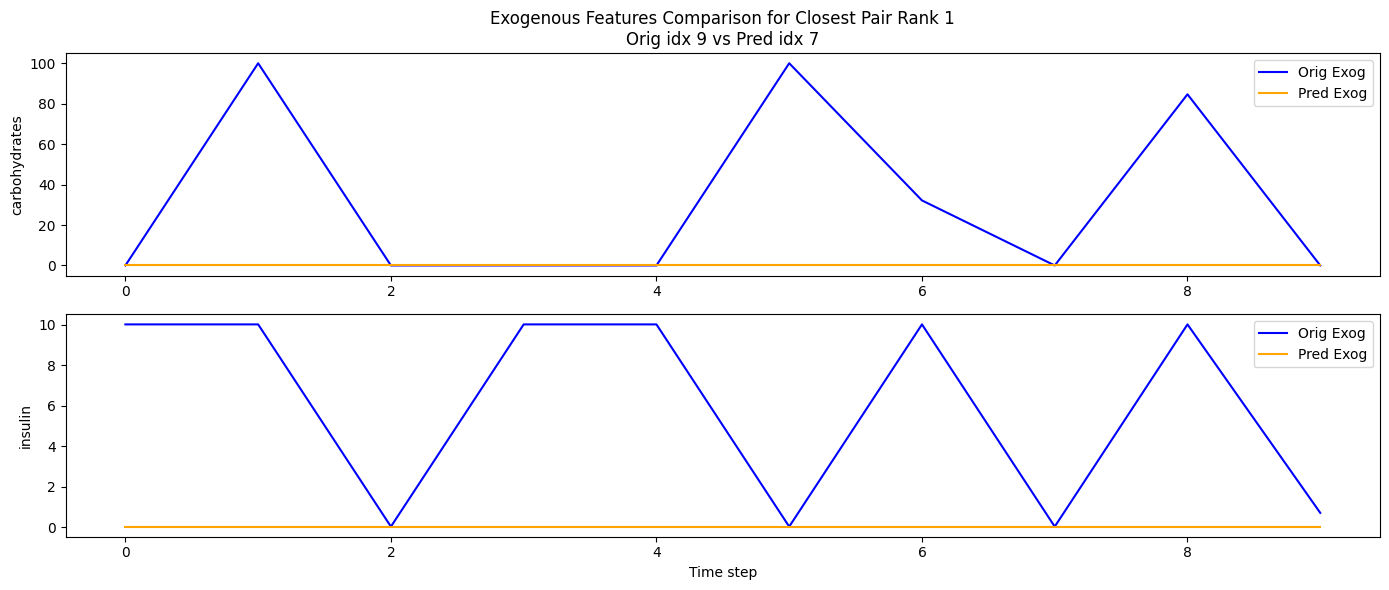

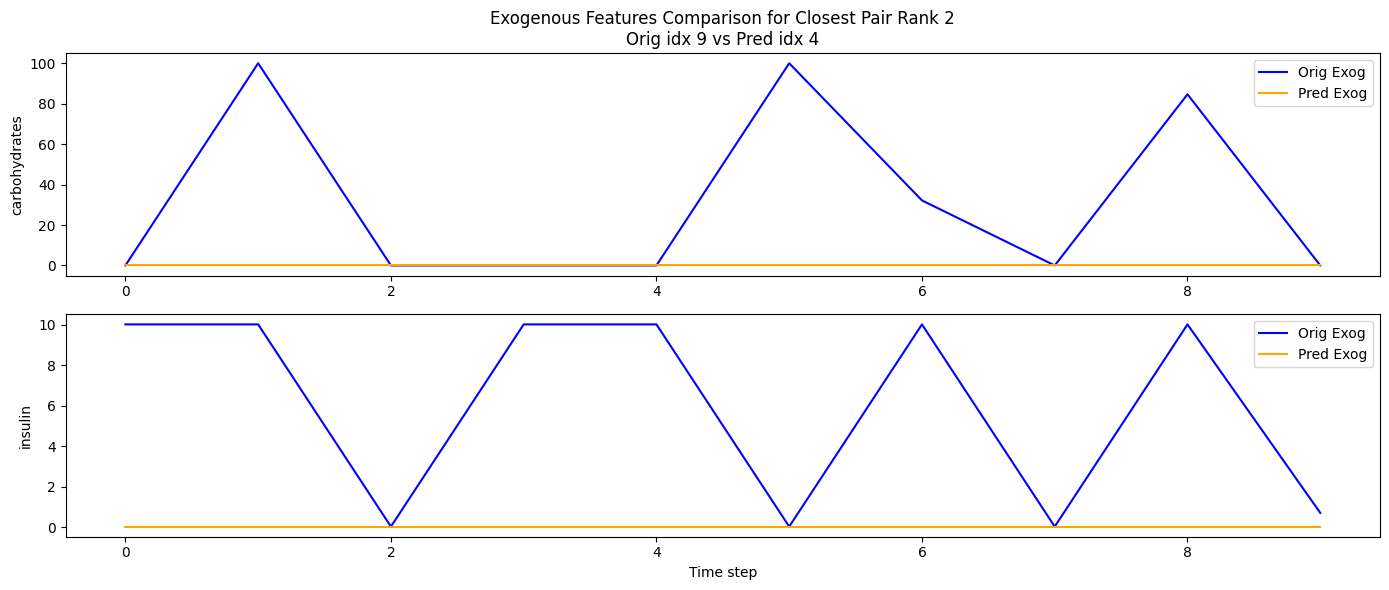

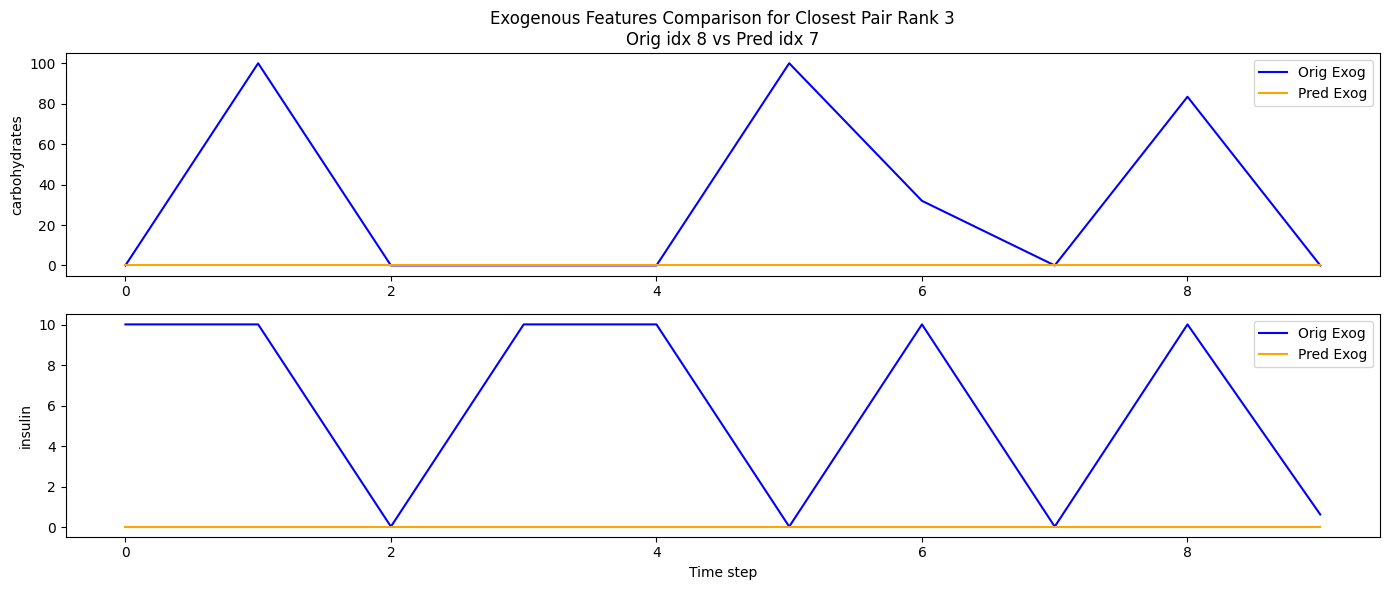

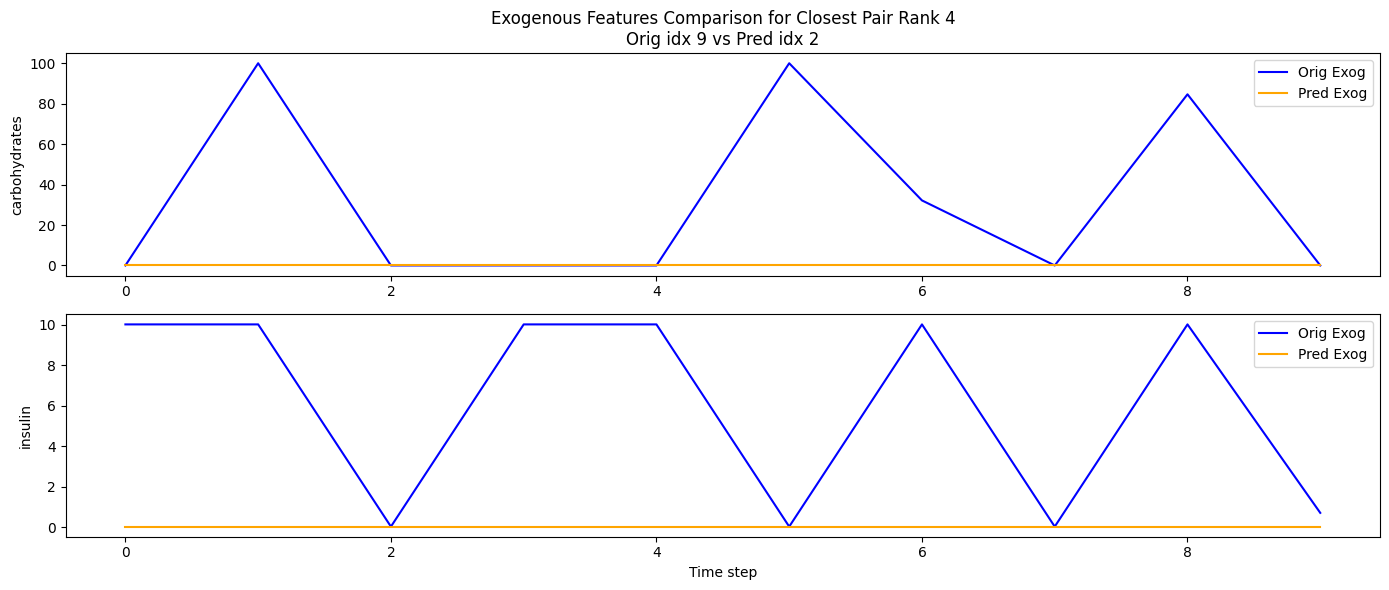

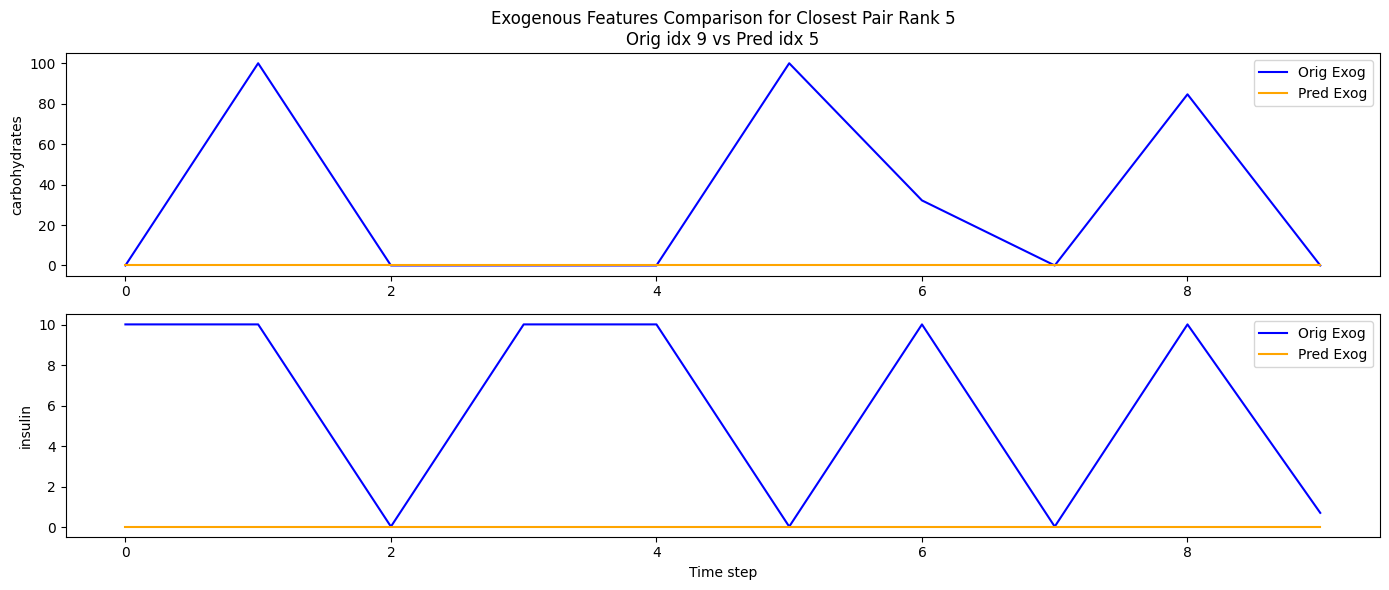

In [66]:
import matplotlib.pyplot as plt

# Assuming closest_pairs is already computed from previous step as list of (orig_idx, pred_idx)

for rank, (orig_idx, pred_idx) in enumerate(sorted(closest_pairs, key=lambda x: dist_matrix[x[0], x[1]]), 1):
    plt.figure(figsize=(12, 6))
    
    timesteps = orig_targets.shape[1]
    time_axis = range(timesteps)
    
    # Plot original target
    plt.plot(time_axis, orig_targets[orig_idx].squeeze(), label='Original Target', color='blue')
    
    # Plot predicted target
    plt.plot(time_axis, pred_targets[pred_idx].squeeze(), label='Predicted Target', color='orange')
    plt.title(f"Similar blood glucose levels original vs. predicted")
    plt.xlabel("Time Step")
    plt.ylabel("Blood Glucose Level")
    plt.legend()
    plt.savefig(f"similar_bg_sim_10_40_{orig_idx}_{pred_idx}.png")
    plt.show()

# closest_pairs: list of (orig_idx, pred_idx)

orig_exogs = transformed_orig_exogs_gru
pred_exogs = transformed_exogs_gru

if args.dataset == "ohiot1dm":
    labels = ["basal insulin", "bolus insulin", "carbohydrates", "exercise intensity"]
    num_exog_vars = 4
elif args.dataset == "simulated":
    labels = ["carbohydrates", "insulin"]
    num_exog_vars = 2
    
for rank, (orig_idx, pred_idx) in enumerate(closest_pairs, 1):
    plt.figure(figsize=(14, 6))
    
    timesteps = orig_exogs.shape[1]
    time_axis = range(timesteps)
    num_features = orig_exogs.shape[2]
    
    for feature_idx in range(num_features):
        plt.subplot(num_features, 1, feature_idx + 1)
        
        # Plot original exog
        plt.plot(time_axis, orig_exogs[orig_idx, :, feature_idx], label='Orig Exog', color='blue')
        
        # Plot predicted exog
        plt.plot(time_axis, pred_exogs[pred_idx, :, feature_idx], label='Pred Exog', color='orange')
        
        plt.ylabel(f'{labels[feature_idx]}')
        if feature_idx == 0:
            plt.title(f'Exogenous Features Comparison for Closest Pair Rank {rank}\nOrig idx {orig_idx} vs Pred idx {pred_idx}')
        if feature_idx == num_features - 1:
            plt.xlabel('Time step')
        
        plt.legend()
    plt.savefig(f"similar_exogs_sim_6_24_{orig_idx}_{pred_idx}.png")    
    plt.tight_layout()
    plt.show()


In [67]:
# Number of features
num_features = orig_exogs.shape[2]

# List to hold distances per pair, per feature
exog_distances_per_feature = []

for orig_idx, pred_idx in closest_pairs:
    distances = []
    for feature_idx in range(num_features):
        # Extract time series for this feature from original and predicted exogs
        orig_feature = orig_exogs[orig_idx, :, feature_idx]
        pred_feature = pred_exogs[pred_idx, :, feature_idx]
        
        # Compute Euclidean distance for this feature
        dist = np.linalg.norm(orig_feature - pred_feature)
        distances.append(dist)
    
    exog_distances_per_feature.append(distances)

# Print distances for each pair and feature
for pair_idx, distances in enumerate(exog_distances_per_feature, 1):
    print(f"Pair {pair_idx}:")
    for feature_idx, dist in enumerate(distances, 1):
        print(f"  Feature {feature_idx} Euclidean distance: {dist:.4f}")


Pair 1:
  Feature 1 Euclidean distance: 167.9240
  Feature 2 Euclidean distance: 24.5043
Pair 2:
  Feature 1 Euclidean distance: 167.9240
  Feature 2 Euclidean distance: 24.5043
Pair 3:
  Feature 1 Euclidean distance: 167.2813
  Feature 2 Euclidean distance: 24.5022
Pair 4:
  Feature 1 Euclidean distance: 167.9240
  Feature 2 Euclidean distance: 24.5043
Pair 5:
  Feature 1 Euclidean distance: 167.9240
  Feature 2 Euclidean distance: 24.5043


In [68]:
import numpy as np

# Use normalized data
orig_targets = orig_targets_gru
pred_targets = targets_gru  # comparing within the same set
orig_exogs = orig_exogs_gru
pred_exogs = exogs_gru

# Compute pairwise Euclidean distances between targets
target_dist_matrix = np.linalg.norm(
    orig_targets[:, np.newaxis, :] - pred_targets[np.newaxis, :, :], axis=2
)

# Get top 5 closest target pairs (excluding identity pairs)
np.fill_diagonal(target_dist_matrix, np.inf)
closest_pairs = np.unravel_index(np.argsort(target_dist_matrix, axis=None)[:5], target_dist_matrix.shape)
closest_pairs = list(zip(closest_pairs[0], closest_pairs[1]))

# Number of features
num_features = orig_exogs.shape[2]

# List to hold distances per pair, per feature
exog_distances_per_feature = []

for orig_idx, pred_idx in closest_pairs:
    distances = []
    for feature_idx in range(num_features):
        # Extract time series for this feature from original and predicted exogs
        orig_feature = orig_exogs[orig_idx, :, feature_idx]
        pred_feature = pred_exogs[pred_idx, :, feature_idx]

        # Compute Euclidean distance for this feature
        dist = np.linalg.norm(orig_feature - pred_feature)
        distances.append(dist)

    exog_distances_per_feature.append(distances)

# Print distances for each pair and feature
for pair_idx, distances in enumerate(exog_distances_per_feature, 1):
    print(f"Pair {pair_idx} (Orig idx: {closest_pairs[pair_idx-1][0]}, Pred idx: {closest_pairs[pair_idx-1][1]}):")
    for feature_idx, dist in enumerate(distances, 1):
        print(f"  Feature {feature_idx} Euclidean distance: {dist:.4f}")


Pair 1 (Orig idx: 68, Pred idx: 0):
  Feature 1 Euclidean distance: 1.2704
  Feature 2 Euclidean distance: 1.2710
Pair 2 (Orig idx: 68, Pred idx: 29):
  Feature 1 Euclidean distance: 1.2704
  Feature 2 Euclidean distance: 1.2710
Pair 3 (Orig idx: 68, Pred idx: 30):
  Feature 1 Euclidean distance: 1.2704
  Feature 2 Euclidean distance: 1.2710
Pair 4 (Orig idx: 68, Pred idx: 31):
  Feature 1 Euclidean distance: 1.2704
  Feature 2 Euclidean distance: 1.2710
Pair 5 (Orig idx: 68, Pred idx: 32):
  Feature 1 Euclidean distance: 1.2704
  Feature 2 Euclidean distance: 1.2710


In [ ]:
print(targets_gru.shape, exogs_gru.shape)

In [ ]:
import numpy as np

# Assume:
# normalized_orig_exogs: shape (n_orig, time_steps, n_features)
# normalized_pred_exogs: shape (n_pred, time_steps, n_features)

# Flatten time and feature dimensions to 2D: shape (n_samples, time_steps * n_features)
flat_orig = targets_gru.reshape(targets_gru.shape[0], -1)
flat_pred = exogs_gru.reshape(flat_pred = exogs_gru.reshape(normalized_pred_exogs.shape[0], -1).shape[0], -1)

# Compute pairwise Euclidean distances
from scipy.spatial.distance import cdist
exog_dist_matrix = cdist(flat_orig, flat_pred, metric='euclidean')  # shape (n_orig, n_pred)


In [ ]:
import numpy as np

def analyse_changes(old_array, new_array):
    old_array = np.array(old_array)
    new_array = np.array(new_array)

    if old_array.shape != new_array.shape:
        raise ValueError("Arrays must be the same shape")

    diff = new_array - old_array
    abs_diff = np.abs(diff)

    avg_change = np.mean(abs_diff)
    fraction_changed = np.mean(old_array != new_array)
    drasticity_std = np.std(diff)
    drasticity_range = np.ptp(diff)  # max - min

    return {
        "average_change": avg_change,
        "fraction_changed": fraction_changed,
        "drasticity_std_dev": drasticity_std,
        "drasticity_range": drasticity_range
    }

def analyse_fit_within_bounds(array, lower_bound, upper_bound):
    array = np.array(array)
    lower_bound = np.array(lower_bound)
    upper_bound = np.array(upper_bound)

    if not (array.shape == lower_bound.shape == upper_bound.shape):
        raise ValueError("All arrays must be the same shape")

    within_bounds = (array >= lower_bound) & (array <= upper_bound)
    fraction_within_bounds = np.mean(within_bounds)

    return {
        "fraction_within_bounds": fraction_within_bounds,
        "total_violations": np.size(array) - np.sum(within_bounds),
        "violated_indices": np.where(~within_bounds)
    }

change_stats = analyse_changes(opt.orig_targets, opt.targets)
fit_stats = analyse_fit_within_bounds(opt.targets, numpy_desired_min, numpy_desired_max)

print("Change Stats:", change_stats)
print("Fit Stats:", fit_stats)


/tmp/ipykernel_14906/2363299163.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=change_labels, y=change_values, ax=axs[0], palette='Blues_r')
/tmp/ipykernel_14906/2363299163.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(change_labels, rotation=15)
/tmp/ipykernel_14906/2363299163.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=fit_labels, y=fit_values, ax=axs[1], palette='Greens_r')
/tmp/ipykernel_14906/2363299163.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax

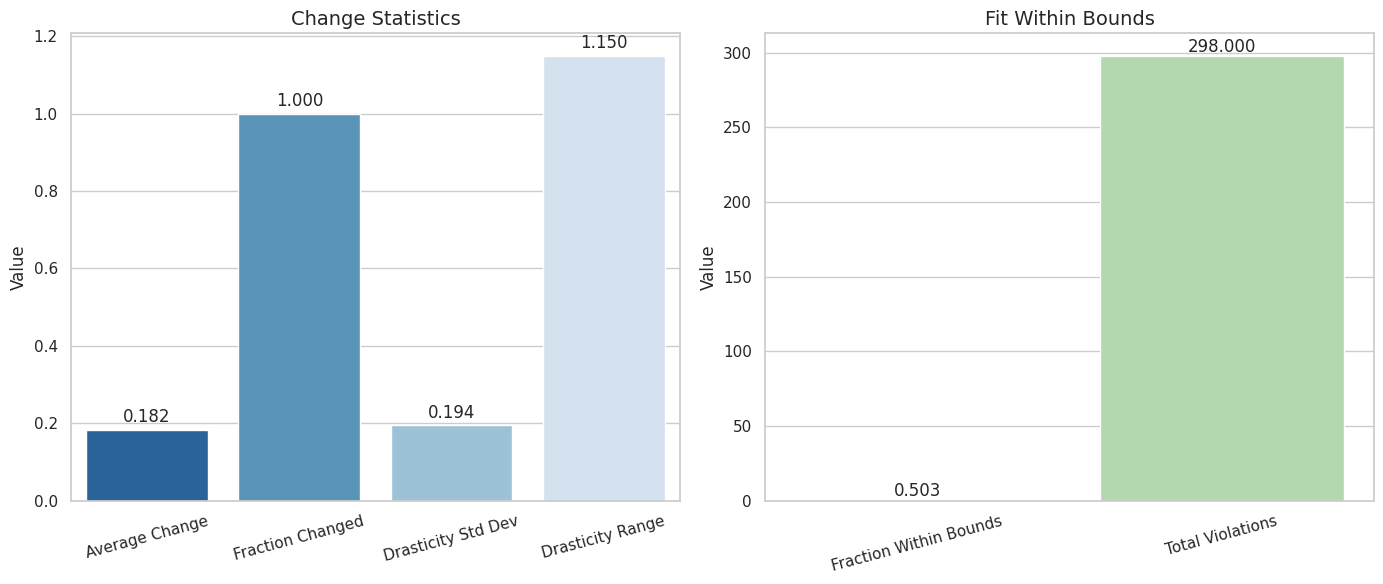

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_stats(change_stats, fit_stats):
    sns.set(style="whitegrid")
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # ---- Plot 1: Change Stats ----
    change_labels = [
        'Average Change',
        'Fraction Changed',
        'Drasticity Std Dev',
        'Drasticity Range'
    ]
    change_values = [
        change_stats['average_change'],
        change_stats['fraction_changed'],
        change_stats['drasticity_std_dev'],
        change_stats['drasticity_range']
    ]

    bars = sns.barplot(x=change_labels, y=change_values, ax=axs[0], palette='Blues_r')
    axs[0].set_title("Change Statistics", fontsize=14)
    axs[0].set_ylabel("Value")
    axs[0].set_xticklabels(change_labels, rotation=15)

    for bar, val in zip(bars.patches, change_values):
        height = bar.get_height()
        axs[0].text(bar.get_x() + bar.get_width() / 2, height + 0.01, f"{val:.3f}", ha='center', va='bottom')

    # ---- Plot 2: Fit Stats ----
    fit_labels = ['Fraction Within Bounds', 'Total Violations']
    fit_values = [
        fit_stats['fraction_within_bounds'],
        fit_stats['total_violations']
    ]

    bars = sns.barplot(x=fit_labels, y=fit_values, ax=axs[1], palette='Greens_r')
    axs[1].set_title("Fit Within Bounds", fontsize=14)
    axs[1].set_ylabel("Value")
    axs[1].set_xticklabels(fit_labels, rotation=15)

    for bar, val in zip(bars.patches, fit_values):
        height = bar.get_height()
        axs[1].text(bar.get_x() + bar.get_width() / 2, height + 0.01, f"{val:.3f}", ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


change_stats = analyse_changes(opt.orig_targets, opt.targets)
fit_stats = analyse_fit_within_bounds(opt.targets, numpy_desired_min, numpy_desired_max)

plot_stats(change_stats, fit_stats)


/tmp/ipykernel_14906/82482816.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.arange(len(mean_per_feature_change)), y=mean_per_feature_change, ax=axs[1, 0], palette="coolwarm")


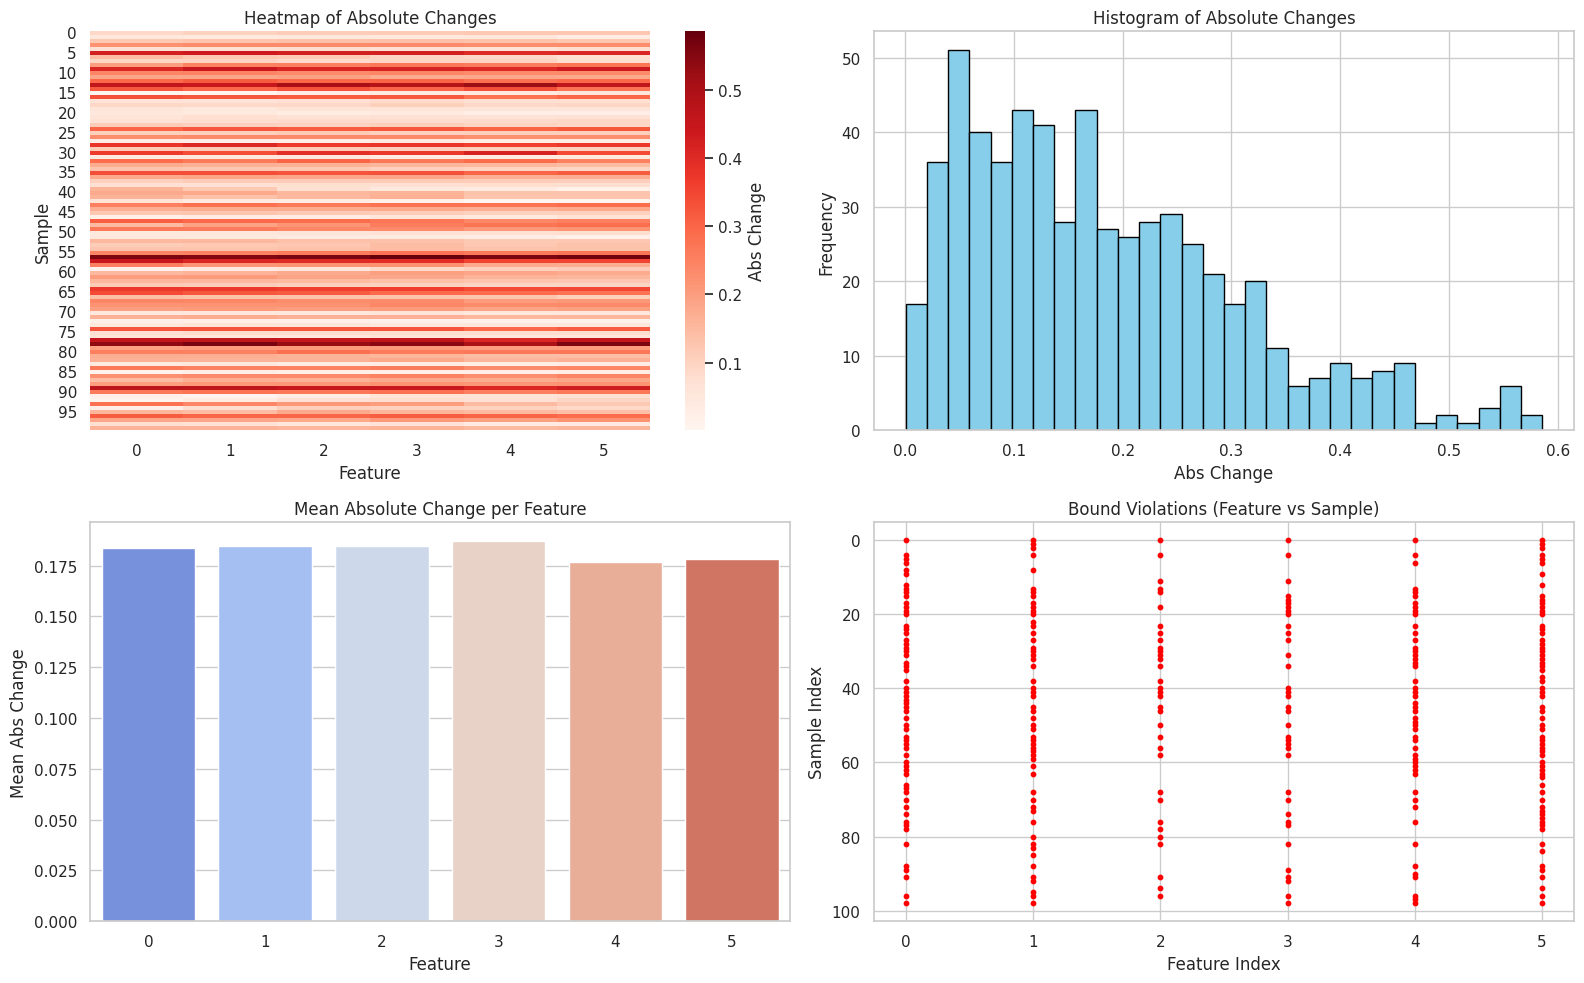

In [30]:
def plot_detailed_stats(old_array, new_array, lower_bound, upper_bound):
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    old_array = np.array(old_array)
    new_array = np.array(new_array)
    lower_bound = np.array(lower_bound)
    upper_bound = np.array(upper_bound)

    diff = new_array - old_array
    abs_diff = np.abs(diff)
    within_bounds = (new_array >= lower_bound) & (new_array <= upper_bound)
    violations = ~within_bounds

    fig, axs = plt.subplots(2, 2, figsize=(16, 10))
    sns.set(style="whitegrid")

    # 1. Heatmap of absolute changes
    sns.heatmap(abs_diff, ax=axs[0, 0], cmap="Reds", cbar_kws={'label': 'Abs Change'})
    axs[0, 0].set_title("Heatmap of Absolute Changes")
    axs[0, 0].set_xlabel("Feature")
    axs[0, 0].set_ylabel("Sample")

    # 2. Histogram of absolute changes
    axs[0, 1].hist(abs_diff.flatten(), bins=30, color='skyblue', edgecolor='black')
    axs[0, 1].set_title("Histogram of Absolute Changes")
    axs[0, 1].set_xlabel("Abs Change")
    axs[0, 1].set_ylabel("Frequency")

    # 3. Bar plot of per-feature average change
    mean_per_feature_change = abs_diff.mean(axis=0)
    sns.barplot(x=np.arange(len(mean_per_feature_change)), y=mean_per_feature_change, ax=axs[1, 0], palette="coolwarm")
    axs[1, 0].set_title("Mean Absolute Change per Feature")
    axs[1, 0].set_xlabel("Feature")
    axs[1, 0].set_ylabel("Mean Abs Change")

    # 4. Scatter plot of violations
    violation_indices = np.argwhere(violations)
    axs[1, 1].scatter(violation_indices[:, 1], violation_indices[:, 0], c='red', s=10)
    axs[1, 1].set_title("Bound Violations (Feature vs Sample)")
    axs[1, 1].set_xlabel("Feature Index")
    axs[1, 1].set_ylabel("Sample Index")
    axs[1, 1].invert_yaxis()

    plt.tight_layout()
    plt.show()

plot_detailed_stats(opt.orig_targets, opt.targets, numpy_desired_min, numpy_desired_max)


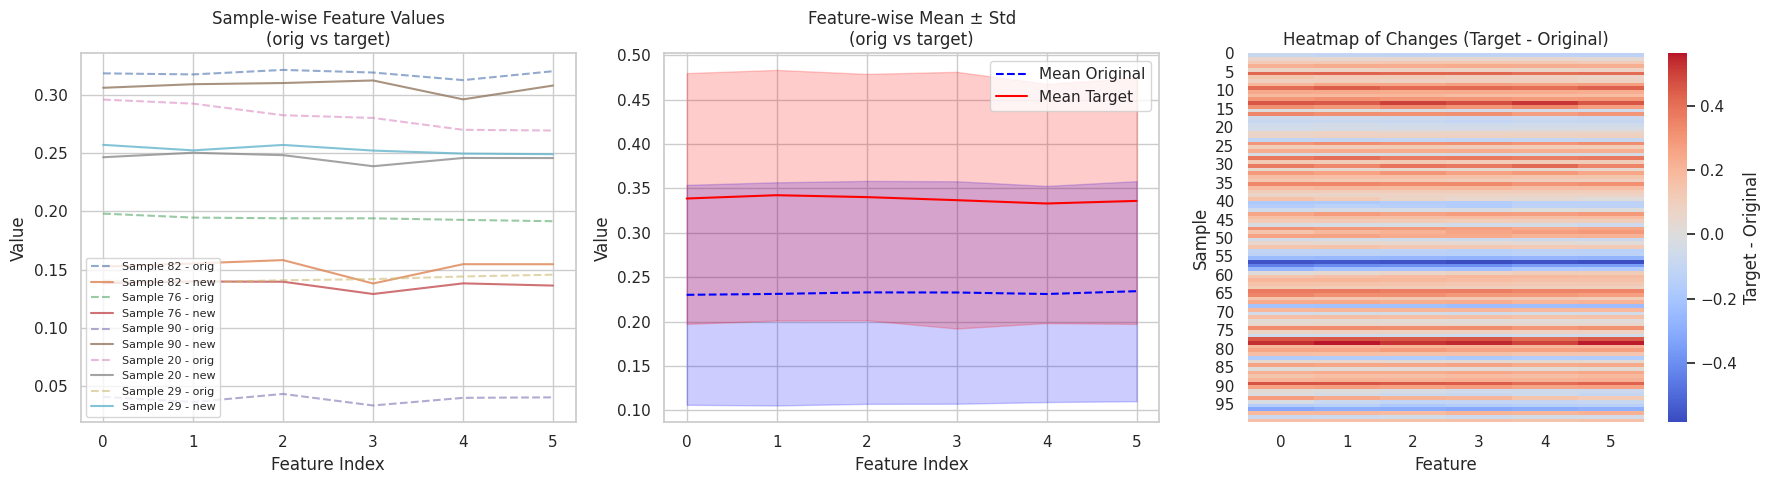

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_orig_vs_target(orig_targets, targets, num_samples_to_plot=5):
    orig = np.array(orig_targets)
    new = np.array(targets)
    
    if orig.shape != new.shape:
        raise ValueError("Shape mismatch between original and new arrays")
    
    num_samples, num_features = orig.shape

    sns.set(style="whitegrid")
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # 1. Line plot for a few random samples
    sample_indices = np.random.choice(num_samples, num_samples_to_plot, replace=False)
    for idx in sample_indices:
        axs[0].plot(orig[idx], label=f'Sample {idx} - orig', linestyle='--', alpha=0.6)
        axs[0].plot(new[idx], label=f'Sample {idx} - new', linestyle='-', alpha=0.8)
    
    axs[0].set_title("Sample-wise Feature Values\n(orig vs target)")
    axs[0].set_xlabel("Feature Index")
    axs[0].set_ylabel("Value")
    axs[0].legend(fontsize=8)

    # 2. Overlay plot for all samples (mean and std bands)
    mean_orig = orig.mean(axis=0)
    mean_new = new.mean(axis=0)

    axs[1].plot(mean_orig, label="Mean Original", linestyle='--', color='blue')
    axs[1].plot(mean_new, label="Mean Target", linestyle='-', color='red')

    axs[1].fill_between(
        np.arange(num_features),
        mean_orig - orig.std(axis=0),
        mean_orig + orig.std(axis=0),
        color='blue', alpha=0.2
    )
    axs[1].fill_between(
        np.arange(num_features),
        mean_new - new.std(axis=0),
        mean_new + new.std(axis=0),
        color='red', alpha=0.2
    )

    axs[1].set_title("Feature-wise Mean ± Std\n(orig vs target)")
    axs[1].set_xlabel("Feature Index")
    axs[1].set_ylabel("Value")
    axs[1].legend()

    # 3. Heatmap of deltas (orig - new)
    diff = new - orig
    sns.heatmap(diff, cmap="coolwarm", center=0, ax=axs[2], cbar_kws={'label': 'Target - Original'})
    axs[2].set_title("Heatmap of Changes (Target - Original)")
    axs[2].set_xlabel("Feature")
    axs[2].set_ylabel("Sample")

    plt.tight_layout()
    plt.show()



plot_orig_vs_target(opt.orig_targets, opt.targets)


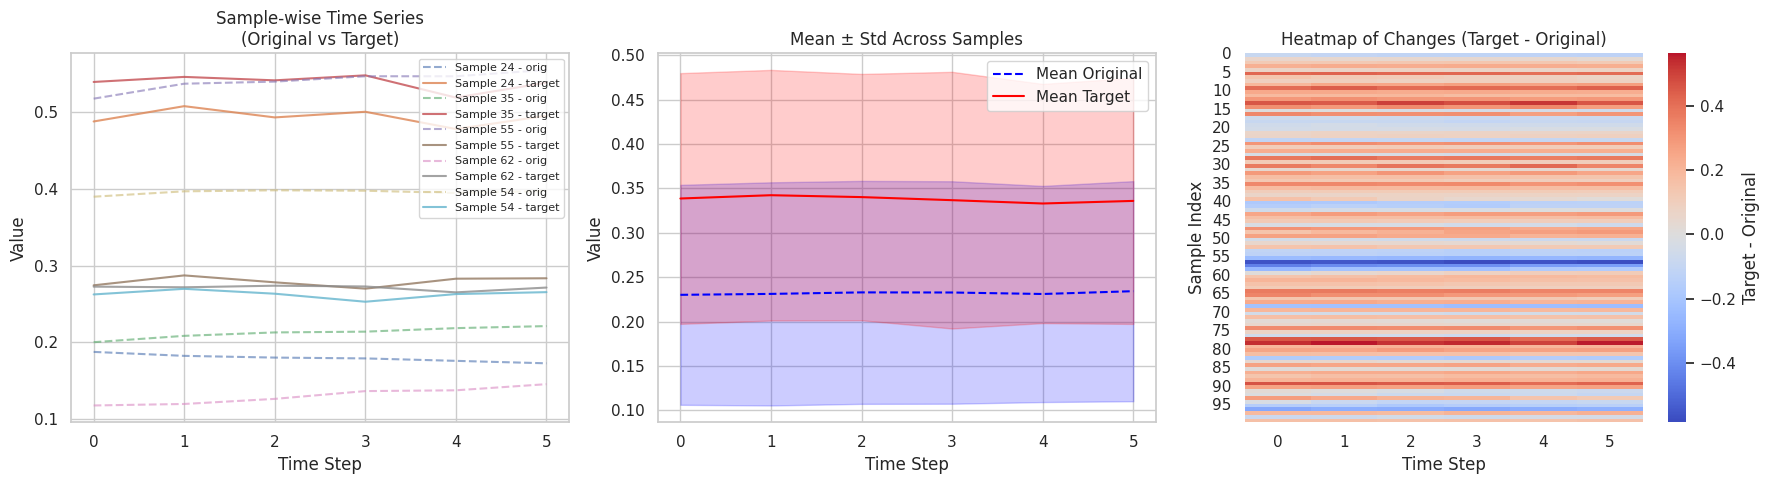

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_orig_vs_target_timeseries(orig_targets, targets, num_samples_to_plot=5):
    orig = np.array(orig_targets)
    new = np.array(targets)
    
    if orig.shape != new.shape:
        raise ValueError("Shape mismatch between original and new arrays")

    num_samples, num_timesteps = orig.shape

    sns.set(style="whitegrid")
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # 1. Time series plots for a few random samples
    sample_indices = np.random.choice(num_samples, num_samples_to_plot, replace=False)
    for idx in sample_indices:
        axs[0].plot(orig[idx], label=f'Sample {idx} - orig', linestyle='--', alpha=0.6)
        axs[0].plot(new[idx], label=f'Sample {idx} - target', linestyle='-', alpha=0.8)

    axs[0].set_title("Sample-wise Time Series\n(Original vs Target)")
    axs[0].set_xlabel("Time Step")
    axs[0].set_ylabel("Value")
    axs[0].legend(fontsize=8)
    plt.savefig("0_gru.png")

    # 2. Mean ± std band plot across all samples
    mean_orig = orig.mean(axis=0)
    mean_new = new.mean(axis=0)
    std_orig = orig.std(axis=0)
    std_new = new.std(axis=0)

    axs[1].plot(mean_orig, label="Mean Original", linestyle='--', color='blue')
    axs[1].plot(mean_new, label="Mean Target", linestyle='-', color='red')

    axs[1].fill_between(np.arange(num_timesteps), mean_orig - std_orig, mean_orig + std_orig, color='blue', alpha=0.2)
    axs[1].fill_between(np.arange(num_timesteps), mean_new - std_new, mean_new + std_new, color='red', alpha=0.2)

    axs[1].set_title("Mean ± Std Across Samples")
    axs[1].set_xlabel("Time Step")
    axs[1].set_ylabel("Value")
    axs[1].legend()
    plt.savefig("1_gru.png")

    # 3. Heatmap of differences (target - original) per sample
    diff = new - orig
    sns.heatmap(diff, cmap="coolwarm", center=0, ax=axs[2], cbar_kws={'label': 'Target - Original'})
    axs[2].set_title("Heatmap of Changes (Target - Original)")
    axs[2].set_xlabel("Time Step")
    axs[2].set_ylabel("Sample Index")
    plt.savefig("2_gru.png")

    plt.tight_layout()
    plt.show()


plot_orig_vs_target_timeseries(opt.orig_targets, opt.targets)


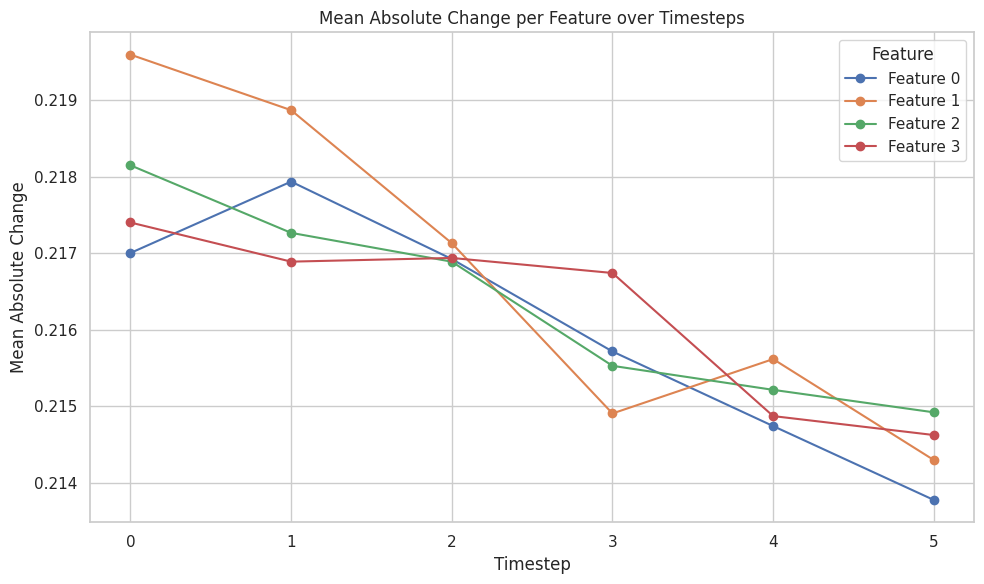

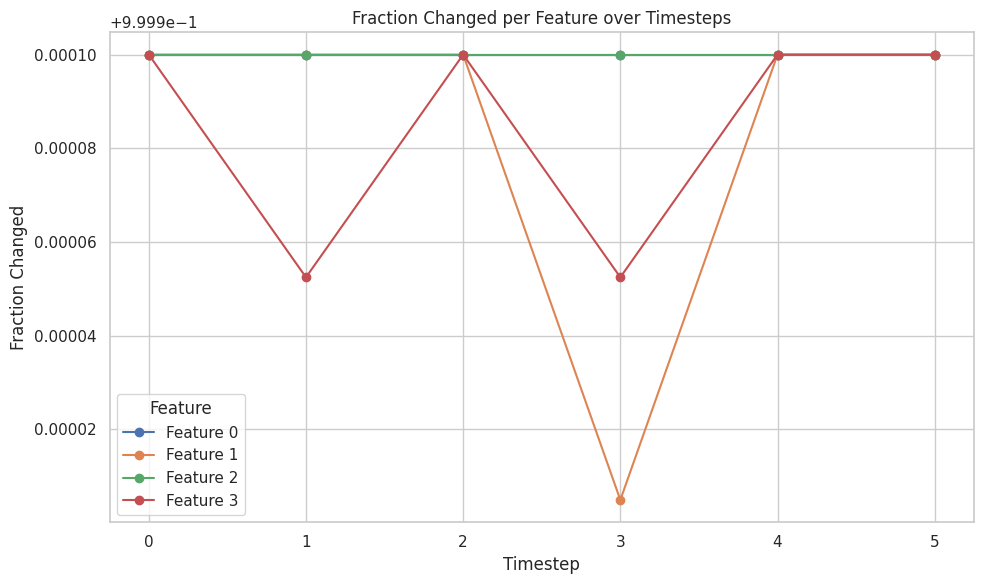

In [140]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_changes_over_time(old_array, new_array, stat='mean'):
    old = np.array(old_array)
    new = np.array(new_array)

    if old.shape != new.shape:
        raise ValueError("Shape mismatch between original and new arrays")

    abs_diff = np.abs(new - old)  # shape: (samples, timesteps, features)

    if stat == 'mean':
        data = abs_diff.mean(axis=0)  # shape: (timesteps, features)
        ylabel = "Mean Absolute Change"
    elif stat == 'std':
        data = abs_diff.std(axis=0)
        ylabel = "Std Dev of Change"
    elif stat == 'fraction':
        data = (abs_diff > 1e-6).mean(axis=0)
        ylabel = "Fraction Changed"
    else:
        raise ValueError("Unsupported stat: choose from 'mean', 'std', 'fraction'")

    timesteps = np.arange(data.shape[0])
    num_features = data.shape[1]

    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    
    for i in range(num_features):
        plt.plot(timesteps, data[:, i], marker='o', label=f"Feature {i}")

    plt.title(f"{ylabel} per Feature over Timesteps")
    plt.xlabel("Timestep")
    plt.ylabel(ylabel)
    plt.xticks(timesteps)
    plt.legend(title="Feature")
    plt.tight_layout()
    plt.savefig(f"absolute_change_{stat}.png")
    plt.show()


plot_feature_changes_over_time(pred_exog, opt.exogs, stat='mean')
plot_feature_changes_over_time(pred_exog, opt.exogs, stat='fraction')


0
[[0.22424486 0.22628564 0.23563561 0.23504877]
 [0.2188115  0.23257205 0.24109128 0.21920429]
 [0.23713034 0.2313942  0.23428693 0.22456709]
 [0.24318771 0.24072641 0.22433344 0.2342072 ]
 [0.22880353 0.23477714 0.23254861 0.23419075]
 [0.24094905 0.23642576 0.25530806 0.23227124]] [[0.03954629 0.496769   0.19813415 0.16125399]
 [0.03276172 0.6044229  0.1900064  0.24212189]
 [0.18882798 0.36929867 0.14375831 0.4584673 ]
 [0.28504127 0.2640898  0.12101551 0.34265462]
 [0.29894325 0.43321428 0.14235254 0.20991178]
 [0.47906253 0.24161644 0.18483248 0.09577516]]


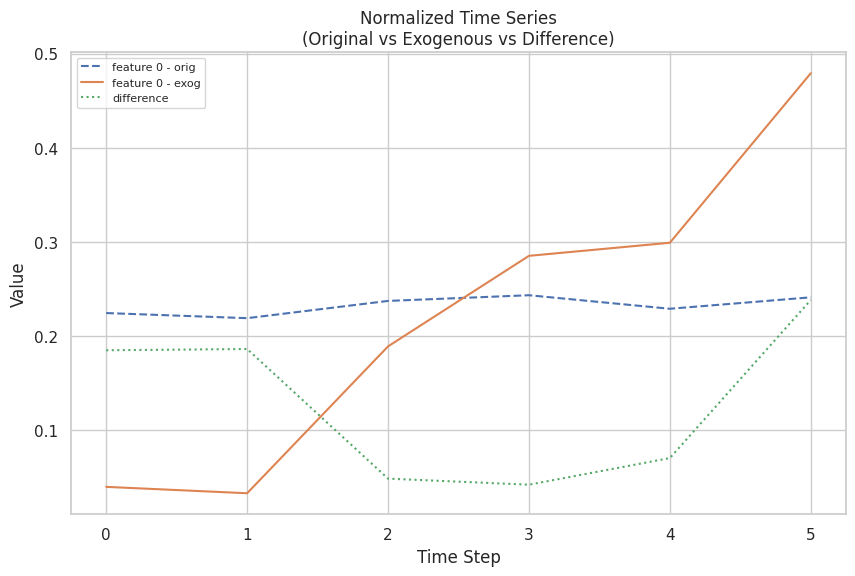

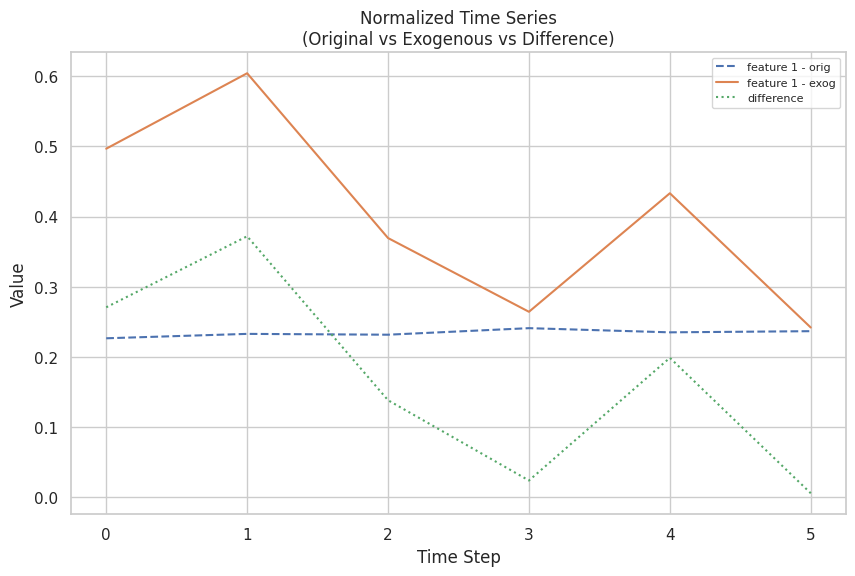

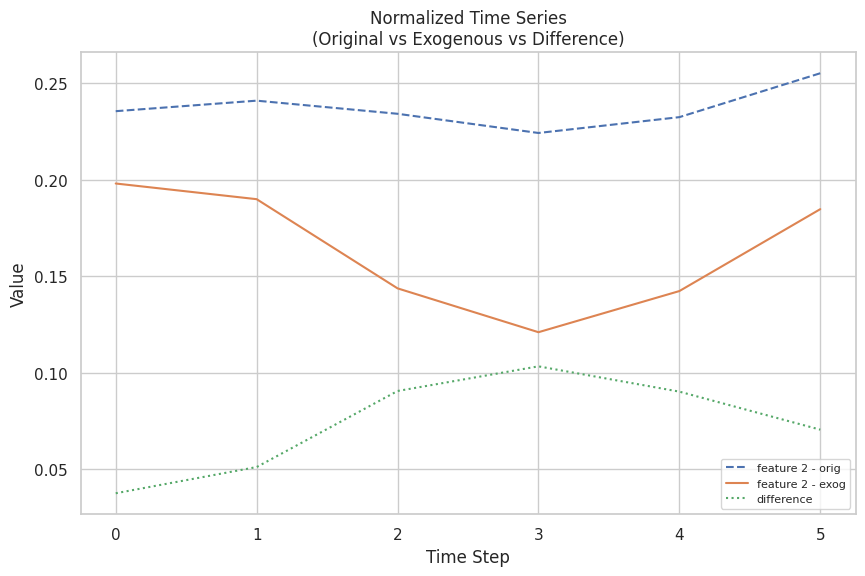

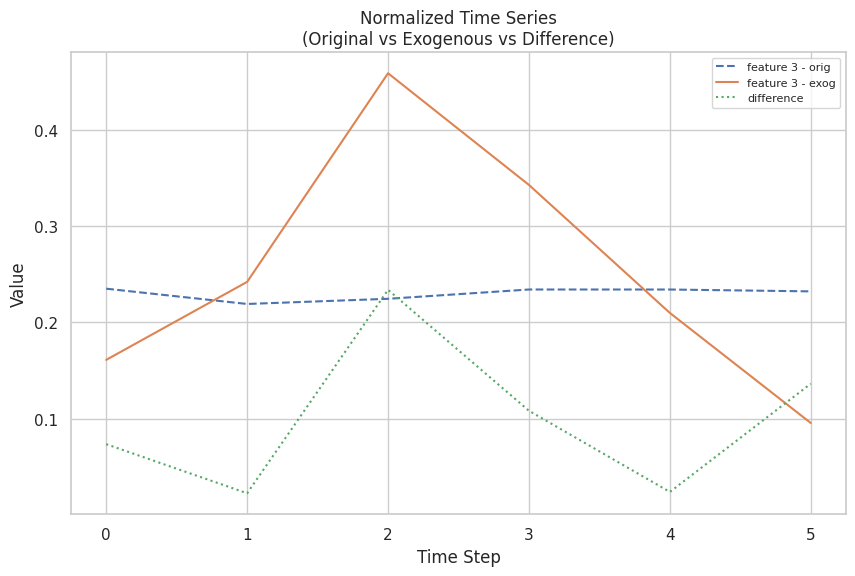

In [167]:
def plot_orig_vs_exogs_timeseries(orig_exogs, exogs, i, num_features):
    orig = np.transpose(np.array(orig_exogs))
    new = np.transpose(np.array(exogs))
    #print("TETETET", orig, new)
    if orig.shape != new.shape:
        raise ValueError("Shape mismatch between original and new arrays")

    num_samples, num_timesteps = orig.shape

    sns.set(style="whitegrid")
    #fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    for i in range(num_features):
        plt.figure(figsize=(10, 6))
    #sample_indices = np.random.choice(num_samples, num_samples_to_plot, replace=False)
    #for idx in sample_indices:
        diff = abs(orig[i]-new[i])
        #print("TESTNEW", diff, orig[i], new[i])
        plt.plot(orig[i], label=f'feature {i} - orig', linestyle='--')
        plt.plot(new[i], label=f'feature {i} - exog', linestyle='-')
        plt.plot(diff, label=f'difference', linestyle=':')
        plt.title("Normalized Time Series\n(Original vs Exogenous vs Difference)")
        plt.xlabel("Time Step")
        plt.ylabel("Value")
        plt.legend(fontsize=8)
        plt.savefig(f"orig_exog_feature{i}.png")


num_samples_to_plot=1
num_samples, num_timesteps, num_features = pred_exog.shape
sample_indices = np.random.choice(num_samples, num_samples_to_plot, replace=False)
for i in range(1):#sample_indices
    print(i)
    print(pred_exog[i], opt.exogs[i])
    plot_orig_vs_exogs_timeseries(pred_exog[i], opt.exogs[i], i, num_features)

1 [[0.03954629 0.496769   0.19813415 0.16125399]
 [0.03276172 0.6044229  0.1900064  0.24212189]
 [0.18882798 0.36929867 0.14375831 0.4584673 ]
 [0.28504127 0.2640898  0.12101551 0.34265462]
 [0.29894325 0.43321428 0.14235254 0.20991178]
 [0.47906253 0.24161644 0.18483248 0.09577516]] [[0.22424486 0.22628564 0.23563561 0.23504877]
 [0.2188115  0.23257205 0.24109128 0.21920429]
 [0.23713034 0.2313942  0.23428693 0.22456709]
 [0.24318771 0.24072641 0.22433344 0.2342072 ]
 [0.22880353 0.23477714 0.23254861 0.23419075]
 [0.24094905 0.23642576 0.25530806 0.23227124]]
DIFF [0.07379478 0.0229176  0.23390022 0.10844742 0.02427897 0.13649608]
DIFF [0.05502234 0.03196548 0.14910567 0.26315948 0.01697791 0.19638856]
DIFF [0.08046876 0.05550937 0.01732145 0.18442291 0.05894296 0.15826863]


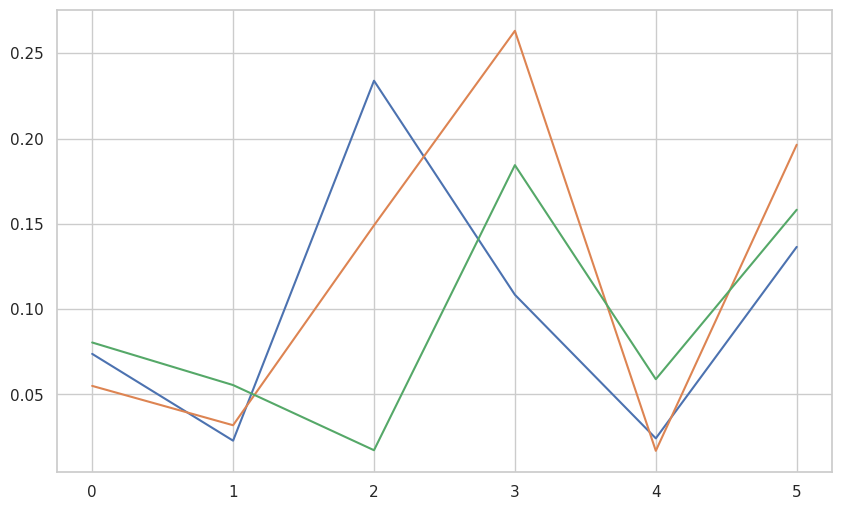

In [145]:
#AVERAGE
def get_average_difference(pred, orig):
    for i in range(pred.shape[1]):
        a_pred = [x[i] for x in pred]
        a_orig = [x[i] for x in orig]
    difference=(abs(np.array(a_pred)-np.array(a_orig)))
    print("DIFF",difference)
    return difference
    

def get_average_of_instance(pred, orig):
    avg_pred, avg_orig, difference = [],[],[]
    for i in range(pred.shape[1]):
        a_pred = [x[i] for x in pred]
        a_orig = [x[i] for x in orig]
        avg_pred.append(np.average(a_pred))
        avg_orig.append(np.average(a_orig))
    return avg_pred, avg_orig

print("1",opt.exogs[0],pred_exog[0])
all_diff = []
for i in range(len(pred_exog)):
    if i < 3:
        #print(opt.exogs[i],pred_exog[i])
    #    results = get_average_of_instance(opt.exogs[i], pred_exog[i])
    #    print(results)
        all_diff.append(get_average_difference(opt.exogs[i], pred_exog[i]))

all_diff = np.transpose(all_diff)

plt.figure(figsize=(10, 6))

plt.plot(all_diff, label='test', linestyle='-')
    

In [135]:
def calc_euclidean(predic, actual):
    return np.sqrt(np.sum((actual - predic) ** 2))

def calc_mape(predic, actual):
    return np.mean(np.abs((actual - predic) / actual))

def calc_correlation(predic, actual):
    a_diff = actual - np.mean(actual)
    p_diff = predic - np.mean(predic)
    numerator = np.sum(a_diff * p_diff)
    denominator = np.sqrt(np.sum(a_diff ** 2)) * np.sqrt(np.sum(p_diff ** 2))
    return numerator / denominator


for i in range(len(pred_exog)):
    if i <3:
        euclidean = calc_euclidean(opt.exogs[i], pred_exog[i])
        mape = calc_mape(opt.exogs[i], pred_exog[i])
        correlation = calc_correlation(opt.exogs[i], pred_exog[i])
        print(euclidean, mape, correlation)

0.729714 0.50813377 0.081727624
1.1836964 0.78292626 -0.26152593
1.0830171 0.8815405 -0.3713419


In [136]:
from sklearn.metrics import r2_score



for i in range(len(pred_exog)):
    if i <3:
        r2 = r2_score(opt.exogs[i], pred_exog[i])
        print(r2)

-1.9969663426418727
-22.47973795304156
-8.449809120697052
